#ALLOY PREDICTION USING THE CATBOOST MODEL

In [1]:
%%time
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00
CPU times: user 1.71 s, sys: 266 ms, total: 1.98 s
Wall time: 11.6 s


In [2]:
%%time
!pip install pymatgen matminer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 27.5 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none-any.whl size=4354

In [3]:
# A library for constructing the Pareto set (multi-objective optimization)
# Read the Docs here: https://pypi.org/project/paretoset/
!pip install paretoset

In [4]:
%%time
# Import useful packages and dependencies
import os
import pandas as pd
import numpy as np
import scipy
import statistics
import math
import re
from pymatgen.core import Element, Composition
from matminer.featurizers.composition import ElementFraction
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition.alloy import Miedema
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
from tqdm import tqdm

import time
from paretoset import paretoset

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import get_cmap

import matplotlib.patches as patches
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec # For more fine-grained layout control of parity plot and shap
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import FormatStrFormatter

from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import Normalize
from scipy import stats
from scipy.interpolate import griddata
import plotly.express as px

import seaborn as sns
import warnings
import string


from itertools import combinations, product
import itertools

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format='retina' #Allow image to have high resolution
np.random.seed(42) # Ensure reproducibility

CPU times: user 5.79 s, sys: 432 ms, total: 6.22 s
Wall time: 10.6 s


In [5]:
%%time
# Import the machine learning models
import catboost
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm, EFstrType # Utility function to perform RFE
print(f"CatBoost version: {catboost.__version__}")

CatBoost version: 1.2.8
CPU times: user 170 ms, sys: 15.3 ms, total: 185 ms
Wall time: 438 ms


In [6]:
%%time
#Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
CPU times: user 913 ms, sys: 159 ms, total: 1.07 s
Wall time: 52 s


In [7]:
%%time
# Setting this options allow Pandas to display every columns. By default only few are displayed.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

CPU times: user 103 µs, sys: 0 ns, total: 103 µs
Wall time: 107 µs


In [8]:
# Featurize the dataframe to create bond properties
%%time
#################################################################################################################################################
#################################################################################################################################################
#################################################################################################################################################
from matminer.featurizers.composition.alloy import Miedema, WenAlloys, YangSolidSolution #Importing featurizers
from matminer.utils.data import MixingEnthalpy, CohesiveEnergyData, DemlData # Importing databases
from matminer.utils import data_files #for importing "Miedema.csv" present inside package of Matminer library
from pymatgen.core.periodic_table import Element
from pymatgen.core.composition import Composition, Element
from matminer.featurizers.composition.packing import AtomicPackingEfficiency


# Import the Guo_Element_property dataset to obtain the correct radius for 'atomic size difference' calculation
Guo_Element_property_data = pd.read_csv('/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/Guo_Element_property.csv', encoding='latin1') # Please replace your own path to the
elem_prop_data = pd.read_csv(os.path.dirname(data_files.__file__) +'/Miedema.csv', na_filter = False)
shear_modulus_element = dict(zip(elem_prop_data['element'], elem_prop_data['shear_modulus']))


# Import Guo dataset
kittel_radius = dict(zip(Guo_Element_property_data['Symbol'], Guo_Element_property_data['Radius/ Å']))
# iti_e = dict(zip(Guo_Element_property_data['Symbol'], Guo_Element_property_data['e/a']))


def compute_gamma_radii(r_i, r_bar):
    """
    Compute Gamma of the radii using metallic radii from Guo dataset.
    The solid angles of the
    atomic packing for the elements with the most significant
    and smallest atomic sizes.

    :math:`\frac{1 - \\sqrt{ \frac{((r + r_{min})^2 - r^2)}{(r + r_{min})^2}}}{1 - \\sqrt{ \frac{((r + r_{max})^2 - r^2)}{(r + r_{max})^2}}}`

    where :math:`r`, :math:`r_{min}` and :math:`r_{max}` are the mean radii
    min radii and max radii.

    Args:
        r_i (list): list of metallic radius of one compound
        r_bar (float): weighted average of the metallic radius

        Returns:
            (float) gamma
    """
    r_i_min = np.min(r_i)
    r_i_max = max(r_i)
    r_bar = r_bar

    numerator = 1 - np.sqrt(((r_bar + r_i_min)**2-r_bar**2) / ((r_bar + r_i_min)**2))
    denominator = 1 - np.sqrt(((r_bar + r_i_max)**2-r_bar**2) / ((r_bar + r_i_max)**2))

    return numerator/denominator

def compute_enthalpy(elements, fractions):
    """
    Compute mixing enthalpy.

    Args:
        elements ([pymatgen.Element or str]): List of elements
        fractions [float]: Fractions of elements in composition

    Returns:
        (float) H_mixing (signed value)
    """
    mixing_enthalpy_source = MixingEnthalpy()

    if len(elements) == 1:
        enthalpy = 0
    else:
        enthalpy = 0
        for i, e1 in enumerate(elements):
            for j, e2 in enumerate(elements[:i]):
                enthalpy += (
                    fractions[i]
                    * fractions[j]
                    * mixing_enthalpy_source.get_mixing_enthalpy(Element(e1), Element(e2))
                )
        enthalpy *= 4

        if enthalpy == 0:
            enthalpy = 1e-6  # Avoid zero if needed for division later

    return enthalpy

def Alloy_Featurizer(composition_matrix): # Takes a pd.Series() of the composition object we created earlier in the first notebook

    """
    The present function takes a composition object column (in our case, the composition objects are located in 'Composition_matrix' columns) and calculates descriptors
    according to Wen et al. (2019) paper: 'Machine learning assisted design of high entropy alloys with desired property'
    Reference:  https://doi.org/10.1016/j.actamat.2019.03.010.
    More details can be found in the supplementary file of the paper. Link:  https://ars.els-cdn.com/content/image/1-s2.0-S1359645419301430-mmc1.pdf

    We emphasize that this code is stricly for crystalline solid solutions like found in our Pd-alloys dataset.
    In the case the compounds are amorphous such as alloy membranes with Group IIIB and IVB as principal solution, the WenAlloys() featurizers from Matminer can be directly used.
    We aim to stay consistent with values published by Magnone et al. (2023) for Pd-alloys
    https://doi.org/10.1016/j.memsci.2023.121513.
    Also, note that matminer converts the units of values e.g J/... to KJ/... most of the time. So values found there might be different from those published by Magnone by a factor of 1000.
    Reference to Matminer source code:https://github.com/hackingmaterials/matminer/blob/main/matminer/featurizers/composition/alloy.py
    Reference Miracle's radius: https://doi.org/10.1179/095066010X12646898728200

    We will use dataset by Guo et al.(2011) to get the data of radius, which is same used by Magnone et al.(2023). The rest of the implementation is intact.
    Reference: https://doi.org/10.1016/S1002-0071(12)60080-X

    Finally, we also convert the units scale to stay consistent with Matminer WenAlloys()
    """

    waf = WenAlloys(impute_nan=True)
    ced = CohesiveEnergyData()
    deml = DemlData()
    VEC_elements = elem_prop_data.set_index('element')['valence_electrons'].to_dict()
    properties = []

    for index, value in composition_matrix.items():

      # Access elements and fractions
      Pd_alloy = list(value.as_dict().keys())
      Pd_alloy_ = list(value.as_dict().values())
      total_mole = sum(Pd_alloy_)

      mole_fraction = [] # List to get mole fractions
      X_i = []  # List to get Pauling electronegativity values
      r_i = []  # List to get metallic radii from Guo assembled dataset (see above)
      Tm_i = [] # List to get melting Temperature
      VEC_i =[] # List to get valence electrons concentration
      Cohesive_i = [] # List to get cohesive energy
      Shear_modulus_i = [] # List to get shear_modulii
      # itinerant_electron_i = [] # List to get e/a values for sum[c_i*(e/a)_i]
      R = 8.314

      for i in Pd_alloy:
        # Use 'index' to access the current composition
        mole_fraction.append(composition_matrix[index].get_atomic_fraction(i)) # We are giving mole percent values so, .get_atomic_fration(i) will only divide by 100.
        X_i.append(Element(i).X) # Calculates individual electronegativity using "Element" function
        r_i.append(kittel_radius[i]) # The value of r_i are collected from the book by Kittel 'Introduction to solid state Physics'
        Tm_i.append(Element(i).melting_point) # Calculating melting point of every element using "Element" class and function
        Cohesive_i.append(ced.get_elemental_property(elem=i, property_name='cohesive energy'))
        # itinerant_electron_i.append(iti_e[i])
        Shear_modulus_i.append(shear_modulus_element[i])

        try:
          VEC_i.append(deml.get_elemental_property(Element(i), "valence")) # Try to get VEC from "DemlData" dataset

        except KeyError:
          if i in VEC_elements:
            VEC_i.append(float(VEC_elements.get(i))) # get VEC from Miedema.csv

      # Calculation of Atomic Radius Difference
      r_bar = np.dot(mole_fraction, r_i)  # Unit in Angstrom
      term = (1-np.divide(r_i, r_bar))**2
      atomic_size_difference = (np.dot(mole_fraction, term)**0.5)

      # Electronegativity # This is the electonegativity difference
      X_bar = np.dot(mole_fraction, X_i)
      del_Chi = np.dot(mole_fraction, (np.subtract(X_i, X_bar))**2)**0.5  # This is the electronegativity

      # Compute chi_local_mismatch
      chi_local_mismatch = waf.compute_local_mismatch(variable = X_i, fractions = mole_fraction)

      # Valence Electron Concentration
      VEC = np.dot(mole_fraction, VEC_i)

      # Compute average cohesive
      mean_cohesive_energy = np.dot(mole_fraction, Cohesive_i)*96.4853 # to convert eV/atom ---> KJ/mol multiply by 96.4853

      # Mean shear modulus
      mean_shear_modulus = np.dot(Shear_modulus_i, mole_fraction)*10**9  # (in GPa) ---> Convert in Pa

      # Average Melting Temperature (K)
      Tm = np.dot(mole_fraction, Tm_i)

      # Compute delta_H_mix using modified Matminer's code. We force the code not to give us absolute value
      delta_H_mix =  compute_enthalpy(Pd_alloy, mole_fraction) # Returns enthalpy in KJ/mol, not abs(enthalpy) like in the original code

      # Entropy of mixing or Configuration entropy
      del_Smix = -R*np.dot(mole_fraction, np.log(mole_fraction))/1000 # J/K/mol --> KJ/K/mol

      # Omega Parameter (Unitless) # The del_Hmix is in KJ/mol therefore conversion is needed
      if del_Smix==0:
        Omega=0
      else:
        Omega = (Tm*del_Smix)/abs(delta_H_mix)

      # Lambda parameter (Entropy of mixing divided by squared atomic_size_difference)
      if atomic_size_difference != 0:
          Lambda_param = del_Smix/(atomic_size_difference**2)
      else:
          Lambda_param = 0   # KJ/K/mol

      # Gamma radii: Geometric parameter introduced originally by Wang(2015), https://doi.org/10.1016/j.scriptamat.2014.09.010
      gamma_radii = compute_gamma_radii(r_i, r_bar) # Unitless

      # Compute radii_local_mismatch (meter)
      radii_local_mismatch = waf.compute_local_mismatch(variable = r_i, fractions = mole_fraction)*1.0e-10 # Angstrom --> meter

      # Compute shear_modulus_local_mismatch (Pa)
      shear_modulus_local_mismatch = waf.compute_local_mismatch(variable = Shear_modulus_i, fractions = mole_fraction)*1.0e9 # GPa --> Pa

      # Compute modulus mismatch in strengthening model (Unitless)
      shear_modulus_strength_model = waf.compute_strength_local_mismatch_shear(Shear_modulus_i, mean_shear_modulus, mole_fraction)

      # Compute shear modulus delta (Unitless)
      shear_modulus_delta = waf.compute_delta(Shear_modulus_i, mole_fraction)

      # Compute itinerant electron  per atom (Link to ref: https://new.math.uiuc.edu/oldnew/quasicrystals/IonBaianu/MizutaniLect-CMA1EU.pdf#page=4.00)
      # itinerant_e_per_atom = np.dot(itinerant_electron_i,  mole_fraction)     # Inconsistent data

      # Collecting all values
      properties.append([len(Pd_alloy),
                         " ".join(Pd_alloy),
                         " ".join(list(map(str, Pd_alloy_))),
                         total_mole,
                         round(sum(mole_fraction),2),
                         atomic_size_difference,
                         del_Chi,
                         delta_H_mix,
                         del_Smix,
                         Omega,
                         VEC,
                         Tm,
                         Lambda_param,
                         gamma_radii,
                         mean_cohesive_energy,
                         radii_local_mismatch,
                         chi_local_mismatch,
                         mean_shear_modulus,
                         shear_modulus_strength_model,
                         shear_modulus_delta,
                         shear_modulus_local_mismatch
                         ])

    prop_data = pd.DataFrame(properties, columns=[
                                                  'No of Components',
                                                  'Component',
                                                  'Moles of individual Components',
                                                  'Total Moles',
                                                  'Sum of individual Mole Fractions',
                                                  'Atomic Size diff. (δ)',
                                                  'Δχ',  # (percent or unitless)
                                                  'ΔHmix', # (KJ/mol)
                                                  'ΔSmix', # (J/K/mol) ---> KJ/K/mol
                                                  'Omega (Ω)', # (unitless)
                                                  'VEC', # (percentage)
                                                  'Melting Temperature', # (unit: Kelvin)
                                                  'Λ',  # Entropy devided by squared atomic_size_difference # (J/K/mol) ---> KJ/K/mol
                                                  'γ', # gamma_radii (unitless)
                                                  'Mean Cohesive Energy', #  (eV/atom) or KJ/mol add conversion factor (multiply by 96.4853 to convert to KJ/mol)
                                                  'D⋅r',  # radii local mismatch (needs unit same as r (Å)) Å --> m
                                                  'D⋅χ',  # Electronegativity local mismatch
                                                  'G',  # mean_shear_modulus (GPa)
                                                  'η',  # shear_modulus_strength_model (unitless)
                                                  'δG',   # shear_modulus_delta
                                                  'D⋅G', # Shear modulus local mismatch (Pa)
                                                  ]
                             )
    return prop_data
#################################################################################################################################################
#################################################################################################################################################
#################################################################################################################################################

CPU times: user 9.22 ms, sys: 964 µs, total: 10.2 ms
Wall time: 1.06 s


In [9]:
%%time
# Function to select the best model
def select_best_model(Result_Block_Bootstrap_Metrics):
  # Select the best model automatically based on One-SE rule and Occam's razor

  # Define the One-SE region
  x_min_idx = int(np.int64(Result_Block_Bootstrap_Metrics[Result_Block_Bootstrap_Metrics['mae_mean']==Result_Block_Bootstrap_Metrics['mae_mean'].min()].index))
  best_mae = Result_Block_Bootstrap_Metrics['mae_mean'].min()
  x_highest = best_mae+Result_Block_Bootstrap_Metrics.loc[x_min_idx, 'mae_std_err']

  # Identify every model within the One-SE region
  One_SE_frame = Result_Block_Bootstrap_Metrics[(Result_Block_Bootstrap_Metrics['mae_mean']>=best_mae) & (Result_Block_Bootstrap_Metrics['mae_mean']<x_highest)]

  # Select the best model
  best_model_frame = One_SE_frame[One_SE_frame['number_of_features']==One_SE_frame['number_of_features'].min()]

  return best_model_frame

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 8.58 µs


In [10]:
%%time
# Virtual ternary alloys generator function

def generate_virtual_Cu_Pd_M(elements, order="CuPdM"):
    # x = Pd in 0.1 at% units: 35.0..50.0  -> 350..500
    # y = M  in 0.1 at% units:  0.1..20.0  ->   1..200
    for M in elements:
        for xi in range(350, 500 + 1):
            for yi in range(1, 200 + 1):
                x = xi / 10.0   # Pd
                y = yi / 10.0   # M
                z = (1000 - xi - yi) / 10.0  # Cu, stays on 0.1 grid
                if order == "CuPdM":
                    yield f"Cu{z:.1f}Pd{x:.1f}{M}{y:.1f}"
                else:
                    yield f"Pd{x:.1f}Cu{z:.1f}{M}{y:.1f}"

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


In [11]:
%%time
# Modify the scale of the cbar
def scientific_formatter(x, pos):
    exponent = int(np.floor(np.log10(x))) if x != 0 else 0
    coeff = x / 10**exponent if x != 0 else 0
    return r"${:.1f}\times10^{{{}}}$".format(coeff, exponent)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.72 µs


In [12]:
%%time
# Add estimated lattice parameters in Angstroms (approximate for common crystal structures)
#alpha Fe
#alpha Cr
#Hf value are obtained from Russell ...Pearson Handbook
#alpha Mn
Lattice_dict = {
    'Fe': 2.8665, 'Cr': 2.8848, 'Nb': 3.3004, 'Ta': 3.303,
    'V': 3.024, 'Mo':3.147, 'W': 3.1652, 'Ag': 4.086137358,
    'Au': 4.078522006, 'Re': 3.2383, 'Ru': 3.82651486, 'Rh': 3.804469536,
    'Y': 5.168622117, 'Ce': 5.1612, 'Ni': 3.52, 'Ir': 3.83873862,
    'Pt': 3.92391032, 'Co': 3.54414474, 'La': 5.2956757, 'In': 4.71131457,
    'Mg': 3.7720, 'Al': 4.049463426, 'Ti': 3.44168611, 'Pd': 3.8903,
    'Cu': 3.614686948, 'Hf':3.72166, 'Ga':5.389965281, 'Sc':3.87288534,
    'Zn':3.275102508, 'Zr':3.7738, 'Mn': 8.9129679
}

def ternary_alloy_lattice_param_calculator(formula):
    comp = Composition(formula)
    a = comp.as_dict()

    if 'Pd' not in a or 'Cu' not in a:
        raise ValueError("Formula must contain both Pd and Cu")

    elements = list(a.keys())

    Pd = comp.get_atomic_fraction('Pd')
    Cu = comp.get_atomic_fraction('Cu')

    minor_elements = [el for el in elements if el not in ['Pd', 'Cu']]
    total = sum(a.values())/100

    others = {el: comp.get_atomic_fraction(el) for el in minor_elements}

    X_PdCu = 1 - sum(others.values()) # fraction of PdCu binary
    X_Pd = Pd/X_PdCu
    X_Cu = Cu/X_PdCu

    # Interpolated PdCu lattice parameter
    lattice_PdCu = (1.57e-3) * X_Pd + 2.90  # See Al Mufachi article for https://doi.org/10.1016/j.memsci.2015.07.015

    # Lattice of alloy
    lattice_alloy = X_PdCu * lattice_PdCu
    for el, at_frac in others.items():
        if el in Lattice_dict:
            lattice_alloy += (at_frac) * Lattice_dict[el]
        else:
            raise ValueError(f"Lattice parameter for element {el} not found in Lattice_dict")

    return lattice_alloy

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 11.2 µs


In [13]:
%%time
def elem_frac(dataframe: pd.DataFrame) -> pd.DataFrame:

    """
    Adds columns for elemental fractions to the input DataFrame based on the 'Composition' column.
    Assumes 'Composition' is a pymatgen Composition object, and 'Component' is a string like 'Pd50Cu50'.
    Returns a new DataFrame with elemental fraction columns added (e.g., 'Pd', 'Cu', etc.).
    """
    dfc = dataframe.copy()

    # Get unique elements from 'Component' column
    component_strings = dfc['Component'].dropna().unique()
    element_sets = [re.findall(r'[A-Z][a-z]*', s) for s in component_strings]
    unique_elements = sorted(set(e for sublist in element_sets for e in sublist))

    # Initialize new columns with zeros
    for el in unique_elements:
        dfc[el] = 0.0

    # Use tqdm for progress bar
    for idx in tqdm(dfc.index, desc='Extracting element fractions'):
        comp_dict = dfc.at[idx, 'Composition'].as_dict()
        for el in comp_dict:
            if el in unique_elements:
                dfc.at[idx, el] = comp_dict[el] / 100  # Assuming percentages

    return dfc

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 8.58 µs


In [14]:
%%time
# Compute metric
def compute_metric(y_true, y_pred):
  result = {'r2': r2_score(y_true, y_pred),
            'mae': mean_absolute_error(y_true, y_pred),
            'rmse':root_mean_squared_error(y_true, y_pred),
            'mse': mean_squared_error(y_true, y_pred),
  }
  return result

# Make prediction
def Predict_permeability(data: pd.DataFrame, virtual_alloys_data_repo:str='/content/drive/MyDrive/PhD_Pd alloy prediction/Virtual_alloys_data', virtual_alloys_file_name:str='data.pkl'):
    """
    Predict new alloys.
    """
    dfc = data.copy()

    # Step 1: Select Final Model Metadata
    final_model_frame = dfc
    feature_set = final_model_frame['combi_name'].iloc[0]
    split_ratio = final_model_frame['split_ratio'].iloc[0]
    number_of_features = final_model_frame['number_of_features'].iloc[0]
    features = list(final_model_frame['features'].iloc[0])
    if 'Melting Tempurature' in features:
      ind = features.index('Melting Tempurature')
      features[ind] = 'Melting Temperature'
    params = final_model_frame['final_model_param'].iloc[0]
    data_type = 'uncorr'
    base_path = '/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Uncorrelated_data_85_size'

    # Step 2: Load Data
    train_file = os.path.join(base_path, f"{feature_set}_train_{split_ratio}_{data_type}.pkl")
    virtual_alloys_file = os.path.join(virtual_alloys_data_repo, virtual_alloys_file_name)

    df_train = pd.read_pickle(train_file)
    df_train = df_train.rename(columns={'Melting Tempurature': 'Melting Temperature'})
    df_test = pd.read_pickle(virtual_alloys_file)
    X_train = df_train[features]
    y_train = df_train['Permeability']
    X_test = df_test[features]

    # Step 3: Scale and Transform
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train_log = np.log1p(y_train)

    X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    # Step 4: Fit Model
    # Now use filtered_params safely
    model = CatBoostRegressor(**params)
    model.fit(Pool(X_train_df, y_train_log), verbose=False)

    # Step 5: Predict new compounds
    y_pred_log= model.predict(X_test_df)
    y_pred = np.expm1(y_pred_log)
    series_new = pd.Series(y_pred, index = X_test_df.index,  name='Predicted_Permeability')

    return pd.concat([df_test, series_new], axis=1)

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 14.3 µs


In [15]:
%%time
# Get the results
Result_Block_Bootstrap_Metrics = pd.read_pickle('/content/drive/MyDrive/PhD_Pd alloy prediction/Bootstrap_results/result_block_bootstrap_metrics_stats.pkl')
Result_Block_Bootstrap_Metrics.head()

CPU times: user 26.7 ms, sys: 17.2 ms, total: 43.9 ms
Wall time: 1.02 s


combi_name  split_ratio  n_split  \
0   Exp_Bond           80        3   
1   Exp_Bond           80        3   
2   Exp_Bond           80        3   
3   Exp_Bond           80        3   
4   Exp_Bond           80        3   

                                            features feature_rank_type  \
0  (D⋅χ, Atomic Size diff. (δ), Pressure differen...            Top 13   
1  (D⋅χ, Atomic Size diff. (δ), Pressure differen...            Top 15   
2  (Atomic Size diff. (δ), Melting Tempurature, D...            Top 20   
3  (Atomic Size diff. (δ), Melting Tempurature, D...            Top 20   
4  (Atomic Size diff. (δ), Melting Tempurature, D...            Top 20   

   number_of_features                                     Consensus_type  \
0                  13  ['D⋅χ', 'Atomic Size diff. (δ)', 'Pressure dif...   
1                  15  ['D⋅χ', 'Atomic Size diff. (δ)', 'Pressure dif...   
2                  20  ['Atomic Size diff. (δ)', 'Melting Tempurature...   
3                  20  ['Atomic Size diff. (δ)', 'Melting Tempurature...   
4                  20  ['Atomic Size diff. (δ)', 'Melting Tempurature...   

          model_name   final_model_mode  Mean_R2_train  Std_R2_train  \
0  CatBoostRegressor  CPU_deterministic         0.9180        0.0644   
1  CatBoostRegressor  CPU_deterministic         0.9401        0.0502   
2  CatBoostRegressor  CPU_deterministic         0.9341        0.0168   
3  CatBoostRegressor  CPU_deterministic         0.9341        0.0168   
4  CatBoostRegressor  CPU_deterministic         0.9341        0.0168   

   Mean_RMSE_train  Std_RMSE_train  Mean_MSE_train  Std_MSE_train  \
0     5.228857e-09    1.835754e-09    3.049743e-17   4.913968e-17   
1     4.398533e-09    2.189913e-09    2.190722e-17   5.864813e-17   
2     4.915078e-09    1.563184e-09    2.448873e-17   4.266876e-17   
3     4.915078e-09    1.563184e-09    2.448873e-17   4.266876e-17   
4     4.915078e-09    1.563184e-09    2.448873e-17   4.266876e-17   

   Mean_MAE_train  Std_MAE_train  Mean_R2_val  Std_R2_val  Mean_RMSE_val  \
0    3.664085e-09   1.688459e-09       0.5467      0.1119   1.289499e-08   
1    3.024024e-09   1.336603e-09       0.5538      0.1367   1.276700e-08   
2    3.374764e-09   5.444402e-10       0.5252      0.0926   1.321902e-08   
3    3.374764e-09   5.444402e-10       0.5252      0.0926   1.321902e-08   
4    3.374764e-09   5.444402e-10       0.5252      0.0926   1.321902e-08   

   Std_RMSE_val  Mean_MSE_val   Std_MSE_val  Mean_MAE_val   Std_MAE_val  \
0  1.835754e-09  1.685275e-16  4.913968e-17  8.524459e-09  1.166657e-09   
1  2.189913e-09  1.661935e-16  5.864813e-17  8.190374e-09  1.251220e-09   
2  1.563184e-09  1.763714e-16  4.266876e-17  8.750320e-09  7.358845e-10   
3  1.563184e-09  1.763714e-16  4.266876e-17  8.750320e-09  7.358845e-10   
4  1.563184e-09  1.763714e-16  4.266876e-17  8.750320e-09  7.358845e-10   

                                        index_values best_iter_per_fold  \
0  [{'fold_idx': 0, 'train_idx': [137, 138, 139, ...    [683, 283, 107]   
1  [{'fold_idx': 0, 'train_idx': [137, 138, 139, ...   [1039, 151, 422]   
2  [{'fold_idx': 0, 'train_idx': [137, 138, 139, ...    [368, 367, 243]   
3  [{'fold_idx': 0, 'train_idx': [137, 138, 139, ...    [368, 367, 243]   
4  [{'fold_idx': 0, 'train_idx': [137, 138, 139, ...    [368, 367, 243]   

    R2_test     RMSE_test      MSE_test      MAE_test  \
0  0.805627  9.482839e-09  8.992424e-17  7.371719e-09   
1  0.816179  9.221858e-09  8.504266e-17  7.141245e-09   
2  0.797190  9.686478e-09  9.382785e-17  7.617872e-09   
3  0.797190  9.686478e-09  9.382785e-17  7.617872e-09   
4  0.797190  9.686478e-09  9.382785e-17  7.617872e-09   

                                       y_test_values  \
0  [1.41e-09, 8.04e-10, 0.0, 3.89e-10, 4.83e-11, ...   
1  [1.41e-09, 8.04e-10, 0.0, 3.89e-10, 4.83e-11, ...   
2  [1.41e-09, 8.04e-10, 0.0, 3.89e-10, 4.83e-11, ...   
3  [1.41e-09, 8.04e-10, 0.0, 3.89e-10, 4.83e-11, ...   
4  [1.41e-09, 8.04e-10, 0.0, 3.89e-10, 4.

In [ ]:
%%time
# The model frame
final_model_frame = select_best_model(Result_Block_Bootstrap_Metrics)

CPU times: user 3.4 ms, sys: 48 µs, total: 3.45 ms
Wall time: 11.7 ms


In [ ]:
# Show
final_model_frame.head()

combi_name  split_ratio  n_split  \
0   Exp_Bond           80        3   

                                            features feature_rank_type  \
0  (D⋅χ, Atomic Size diff. (δ), Pressure differen...            Top 13   

   number_of_features                                     Consensus_type  \
0                  13  ['D⋅χ', 'Atomic Size diff. (δ)', 'Pressure dif...   

          model_name   final_model_mode  Mean_R2_train  Std_R2_train  \
0  CatBoostRegressor  CPU_deterministic          0.918        0.0644   

   Mean_RMSE_train  Std_RMSE_train  Mean_MSE_train  Std_MSE_train  \
0     5.228857e-09    1.835754e-09    3.049743e-17   4.913968e-17   

   Mean_MAE_train  Std_MAE_train  Mean_R2_val  Std_R2_val  Mean_RMSE_val  \
0    3.664085e-09   1.688459e-09       0.5467      0.1119   1.289499e-08   

   Std_RMSE_val  Mean_MSE_val   Std_MSE_val  Mean_MAE_val   Std_MAE_val  \
0  1.835754e-09  1.685275e-16  4.913968e-17  8.524459e-09  1.166657e-09   

                                        index_values best_iter_per_fold  \
0  [{'fold_idx': 0, 'train_idx': [137, 138, 139, ...    [683, 283, 107]   

    R2_test     RMSE_test      MSE_test      MAE_test  \
0  0.805627  9.482839e-09  8.992424e-17  7.371719e-09   

                                       y_test_values  \
0  [1.41e-09, 8.04e-10, 0.0, 3.89e-10, 4.83e-11, ...   

                                  y_test_pred_values  \
0  [5.999318932448262e-09, 5.999318932448262e-09,...   

                                   final_model_param  final_best_iter  \
0  {'iterations': 283, 'learning_rate': 0.03, 'de...              283   

   fitting_time  r2_mean  r2_std_err  r2_lower_ci  r2_upper_ci      mae_mean  \
0      0.959277  0.78466    0.069882     0.613656     0.876341  7.309333e-09   

    mae_std_err  mae_lower_ci  mae_upper_ci     rmse_mean  rmse_std_err  \
0  7.970508e-10  5.684889e-09  8.774847e-09  9.366095e-09  8.753985e-10   

   rmse_lower_ci  rmse_upper_ci  
0   7.479759e-09   1.090872e-08

In [ ]:
final_model_frame['features'].iloc[0]

('D⋅χ',
 'Atomic Size diff. (δ)',
 'Pressure difference',
 'Δa_ss/a_Pd',
 'Melting Tempurature',
 'No of Components',
 'Thickness',
 'Temperature',
 'ΔSmix',
 'δG',
 'η',
 'Λ',
 'ΔHmix')

In [ ]:
%%time
# Generate virtual alloys
elements = ['Mg', 'Al', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Zn', 'Ga', 'Y', 'Zr', 'Nb', 'La', 'Hf', 'Ta']
Virtual_ternary_alloys = list(generate_virtual_Cu_Pd_M(elements, order="PdCuM"))

CPU times: user 368 ms, sys: 15.4 ms, total: 383 ms
Wall time: 383 ms


In [ ]:
%%time
# How many the list does contain
print('The virtual alloys list contains:', len(Virtual_ternary_alloys), 'alloys')

The virtual alloys list contains: 483200 alloys
CPU times: user 68 µs, sys: 0 ns, total: 68 µs
Wall time: 72 µs


In [ ]:
%%time
# Create a dataframe of Virtual_ternary_alloys
Virtual_ternary_alloys_frame = pd.DataFrame({
    'Virtual_alloys':Virtual_ternary_alloys,
    'Composition': [Composition(i) for i in Virtual_ternary_alloys],
})
Virtual_ternary_alloys_frame.head(5)

CPU times: user 4.75 s, sys: 52.9 ms, total: 4.81 s
Wall time: 4.81 s


Virtual_alloys   Composition
0  Pd35.0Cu64.9Mg0.1  (Pd, Cu, Mg)
1  Pd35.0Cu64.8Mg0.2  (Pd, Cu, Mg)
2  Pd35.0Cu64.7Mg0.3  (Pd, Cu, Mg)
3  Pd35.0Cu64.6Mg0.4  (Pd, Cu, Mg)
4  Pd35.0Cu64.5Mg0.5  (Pd, Cu, Mg)

In [ ]:
%%time
# Creating the lattice paramters
Virtual_ternary_alloys_frame['lattice_param'] = Virtual_ternary_alloys_frame['Composition'].apply(ternary_alloy_lattice_param_calculator)

Virtual_ternary_alloys_frame['lattice_param'] = Virtual_ternary_alloys_frame['lattice_param'].apply(lambda x: x*1e-10)
Virtual_ternary_alloys_frame.head()

CPU times: user 3.59 s, sys: 20.8 ms, total: 3.61 s
Wall time: 3.62 s


Virtual_alloys   Composition  lattice_param
0  Pd35.0Cu64.9Mg0.1  (Pd, Cu, Mg)   2.901422e-10
1  Pd35.0Cu64.8Mg0.2  (Pd, Cu, Mg)   2.902294e-10
2  Pd35.0Cu64.7Mg0.3  (Pd, Cu, Mg)   2.903165e-10
3  Pd35.0Cu64.6Mg0.4  (Pd, Cu, Mg)   2.904038e-10
4  Pd35.0Cu64.5Mg0.5  (Pd, Cu, Mg)   2.904909e-10

In [ ]:
%%time
# Creating the lattice mismatch
Virtual_ternary_alloys_frame['Δa_ss/a_Pd'] = Virtual_ternary_alloys_frame['lattice_param'].apply(lambda x: round(((x-3.8901037037037046e-10)/3.8901037037037046e-10), 5))
Virtual_ternary_alloys_frame.head()

CPU times: user 283 ms, sys: 13.7 ms, total: 297 ms
Wall time: 297 ms


Virtual_alloys   Composition  lattice_param  Δa_ss/a_Pd
0  Pd35.0Cu64.9Mg0.1  (Pd, Cu, Mg)   2.901422e-10    -0.25415
1  Pd35.0Cu64.8Mg0.2  (Pd, Cu, Mg)   2.902294e-10    -0.25393
2  Pd35.0Cu64.7Mg0.3  (Pd, Cu, Mg)   2.903165e-10    -0.25370
3  Pd35.0Cu64.6Mg0.4  (Pd, Cu, Mg)   2.904038e-10    -0.25348
4  Pd35.0Cu64.5Mg0.5  (Pd, Cu, Mg)   2.904909e-10    -0.25326

In [ ]:
%%time
# Featurize the dataframe
composition_matrix = Virtual_ternary_alloys_frame['Composition']

#%%
bond_properties = Alloy_Featurizer(composition_matrix)

CPU times: user 34min 26s, sys: 20.5 s, total: 34min 47s
Wall time: 34min 50s


In [ ]:
%%time
# Concatenatte the dataframes and save the files
data_virtual_alloys = pd.concat([Virtual_ternary_alloys_frame, bond_properties], axis=1)

CPU times: user 24.4 ms, sys: 7 ms, total: 31.4 ms
Wall time: 30.8 ms


In [ ]:
%%time
# Show
# 'Pressure difference' ---> 131.0Pa^0.5
#  'Thickness'--> 15 micron *1e6 -->m
#  'Temperature' ---> 673.15
to_transform = ['Pressure difference', 'Thickness', 'Temperature']
data_virtual_alloys['Pressure difference'] = 131.0   #Pa^0.5
data_virtual_alloys['Thickness'] = 15.0*1.0e-6       #m
data_virtual_alloys['Temperature'] = 673.15          #K

CPU times: user 3.34 ms, sys: 0 ns, total: 3.34 ms
Wall time: 2.64 ms


In [ ]:
%%time
# Visualizing
data_virtual_alloys.head()

CPU times: user 141 µs, sys: 1 µs, total: 142 µs
Wall time: 146 µs


Virtual_alloys   Composition  lattice_param  Δa_ss/a_Pd  \
0  Pd35.0Cu64.9Mg0.1  (Pd, Cu, Mg)   2.901422e-10    -0.25415   
1  Pd35.0Cu64.8Mg0.2  (Pd, Cu, Mg)   2.902294e-10    -0.25393   
2  Pd35.0Cu64.7Mg0.3  (Pd, Cu, Mg)   2.903165e-10    -0.25370   
3  Pd35.0Cu64.6Mg0.4  (Pd, Cu, Mg)   2.904038e-10    -0.25348   
4  Pd35.0Cu64.5Mg0.5  (Pd, Cu, Mg)   2.904909e-10    -0.25326   

   No of Components Component Moles of individual Components  Total Moles  \
0                 3  Pd Cu Mg                  35.0 64.9 0.1        100.0   
1                 3  Pd Cu Mg                  35.0 64.8 0.2        100.0   
2                 3  Pd Cu Mg                  35.0 64.7 0.3        100.0   
3                 3  Pd Cu Mg                  35.0 64.6 0.4        100.0   
4                 3  Pd Cu Mg                  35.0 64.5 0.5        100.0   

   Sum of individual Mole Fractions  Atomic Size diff. (δ)        Δχ  \
0                               1.0               0.035928  0.144730   
1                               1.0               0.036576  0.146348   
2                               1.0               0.037211  0.147945   
3                               1.0               0.037833  0.149524   
4                               1.0               0.038443  0.151084   

       ΔHmix     ΔSmix  Omega (Ω)     VEC  Melting Temperature         Λ  \
0 -12.784188  0.005445   0.648220  10.641           1521.93323  4.218327   
1 -12.828352  0.005496   0.651808  10.632           1521.49846  4.107941   
2 -12.872492  0.005542   0.654853  10.623           1521.06369  4.002383   
3 -12.916608  0.005585   0.657541  10.614           1520.62892  3.902206   
4 -12.960700  0.005627   0.659961  10.605           1520.19415  3.807356   

          γ  Mean Cohesive Energy           D⋅r       D⋅χ             G  \
0  1.285752            350.050598  2.232228e-12  0.068839  4.719523e+10   
1  1.285720            349.859557  2.257641e-12  0.069428  4.716746e+10   
2  1.285689            349.668516  2.282989e-12  0.070015  4.713969e+10   
3  1.285657            349.477475  2.308273e-12  0.070601  4.711192e+10   
4  1.285626            349.286435  2.333492e-12  0.071185  4.708415e+10   

          η        δG           D⋅G  Pressure difference  Thickness  \
0 -1.307660  0.063644  1.388192e+09                131.0   0.000015   
1 -1.308918  0.066732  1.415879e+09                131.0   0.000015   
2 -1.310171  0.069685  1.443510e+09                131.0   0.000015   
3 -1.311420  0.072520  1.471086e+09                131.0   0.000015   
4 -1.312663  0.075250  1.498606e+09                131.0   0.000015   

   Temperature  
0       673.15  
1       673.15  
2       673.15  
3       673.15  
4       673.15

In [ ]:
# Saving the dataset
data_virtual_alloys.to_pickle('/content/drive/MyDrive/PhD_Pd alloy prediction/Virtual_alloys_data/data_virtual_alloys.pkl')

In [ ]:
%%time
# Predict the permeability
Prediction_ternary_virtual_alloys = Predict_permeability(data=final_model_frame, virtual_alloys_data_repo='/content/drive/MyDrive/PhD_Pd alloy prediction/Virtual_alloys_data', virtual_alloys_file_name='data_virtual_alloys.pkl')

# Save the prediction
Prediction_ternary_virtual_alloys.to_pickle('/content/drive/MyDrive/PhD_Pd alloy prediction/Virtual_alloys_data/Prediction_ternary_virtual_alloys.pkl')

CPU times: user 5.82 s, sys: 360 ms, total: 6.18 s
Wall time: 12.2 s


In [ ]:
%%time
Prediction_ternary_virtual_alloys = pd.read_pickle('/content/drive/MyDrive/PhD_Pd alloy prediction/Virtual_alloys_data/Prediction_ternary_virtual_alloys.pkl')

CPU times: user 2.67 s, sys: 186 ms, total: 2.86 s
Wall time: 2.9 s


In [ ]:
%%time
Prediction_ternary_virtual_alloys.select_dtypes(include=np.number).isnull().any()

CPU times: user 28.6 ms, sys: 28 ms, total: 56.6 ms
Wall time: 55.8 ms


lattice_param                       False
Δa_ss/a_Pd                          False
No of Components                    False
Total Moles                         False
Sum of individual Mole Fractions    False
Atomic Size diff. (δ)               False
Δχ                                  False
ΔHmix                               False
ΔSmix                               False
Omega (Ω)                           False
VEC                                 False
Melting Temperature                 False
Λ                                   False
γ                                   False
Mean Cohesive Energy                False
D⋅r                                 False
D⋅χ                                 False
G                                   False
η                                   False
δG                                  False
D⋅G                                 False
Pressure difference                 False
Thickness                           False
Temperature                         False
Predicted_Permeability              False
dtype: bool

In [ ]:
%%time
# Generate elemental fraction
virtual_alloys_frame_4_plotting = elem_frac(dataframe=Prediction_ternary_virtual_alloys)
virtual_alloys_frame_4_plotting.to_pickle('/content/drive/MyDrive/PhD_Pd alloy prediction/Virtual_alloys_data/virtual_alloys_frame_4_plotting.pkl')

Extracting element fractions: 100%|██████████| 483200/483200 [00:25<00:00, 19230.61it/s]


CPU times: user 26.3 s, sys: 274 ms, total: 26.6 s
Wall time: 32.6 s


In [ ]:
%%time
virtual_alloys_frame_4_plotting=pd.read_pickle('/content/drive/MyDrive/PhD_Pd alloy prediction/Virtual_alloys_data/virtual_alloys_frame_4_plotting.pkl')

In [ ]:
%%time
# Visualize
virtual_alloys_frame_4_plotting.head()

CPU times: user 142 µs, sys: 0 ns, total: 142 µs
Wall time: 145 µs


Virtual_alloys   Composition  lattice_param  Δa_ss/a_Pd  \
0  Pd35.0Cu64.9Mg0.1  (Pd, Cu, Mg)   2.901422e-10    -0.25415   
1  Pd35.0Cu64.8Mg0.2  (Pd, Cu, Mg)   2.902294e-10    -0.25393   
2  Pd35.0Cu64.7Mg0.3  (Pd, Cu, Mg)   2.903165e-10    -0.25370   
3  Pd35.0Cu64.6Mg0.4  (Pd, Cu, Mg)   2.904038e-10    -0.25348   
4  Pd35.0Cu64.5Mg0.5  (Pd, Cu, Mg)   2.904909e-10    -0.25326   

   No of Components Component Moles of individual Components  Total Moles  \
0                 3  Pd Cu Mg                  35.0 64.9 0.1        100.0   
1                 3  Pd Cu Mg                  35.0 64.8 0.2        100.0   
2                 3  Pd Cu Mg                  35.0 64.7 0.3        100.0   
3                 3  Pd Cu Mg                  35.0 64.6 0.4        100.0   
4                 3  Pd Cu Mg                  35.0 64.5 0.5        100.0   

   Sum of individual Mole Fractions  Atomic Size diff. (δ)        Δχ  \
0                               1.0               0.035928  0.144730   
1                               1.0               0.036576  0.146348   
2                               1.0               0.037211  0.147945   
3                               1.0               0.037833  0.149524   
4                               1.0               0.038443  0.151084   

       ΔHmix     ΔSmix  Omega (Ω)     VEC  Melting Temperature         Λ  \
0 -12.784188  0.005445   0.648220  10.641           1521.93323  4.218327   
1 -12.828352  0.005496   0.651808  10.632           1521.49846  4.107941   
2 -12.872492  0.005542   0.654853  10.623           1521.06369  4.002383   
3 -12.916608  0.005585   0.657541  10.614           1520.62892  3.902206   
4 -12.960700  0.005627   0.659961  10.605           1520.19415  3.807356   

          γ  Mean Cohesive Energy           D⋅r       D⋅χ             G  \
0  1.285752            350.050598  2.232228e-12  0.068839  4.719523e+10   
1  1.285720            349.859557  2.257641e-12  0.069428  4.716746e+10   
2  1.285689            349.668516  2.282989e-12  0.070015  4.713969e+10   
3  1.285657            349.477475  2.308273e-12  0.070601  4.711192e+10   
4  1.285626            349.286435  2.333492e-12  0.071185  4.708415e+10   

          η        δG           D⋅G  Pressure difference  Thickness  \
0 -1.307660  0.063644  1.388192e+09                131.0   0.000015   
1 -1.308918  0.066732  1.415879e+09                131.0   0.000015   
2 -1.310171  0.069685  1.443510e+09                131.0   0.000015   
3 -1.311420  0.072520  1.471086e+09                131.0   0.000015   
4 -1.312663  0.075250  1.498606e+09                131.0   0.000015   

   Temperature  Predicted_Permeability   Al   Cr     Cu   Fe   Ga   Hf   La  \
0       673.15            6.009041e-09  0.0  0.0  0.649  0.0  0.0  0.0  0.0   
1       673.15            6.232663e-09  0.0  0.0  0.648  0.0  0.0  0.0  0.0   
2       673.15            6.446701e-09  0.0  0.0  0.647  0.0  0.0  0.0  0.0   
3       673.15            6.465734e-09  0.0  0.0  0.646  0.0  0.0  0.0  0.0   
4       673.15            6.641279e-09  0.0  0.0  0.645  0.0  0.0  0.0  0.0   

      Mg   Mn   Nb    Pd   Sc   Ta   Ti    V    Y   Zn   Zr  
0  0.001  0.0  0.0  0.35  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.002  0.0  0.0  0.35  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.003  0.0  0.0  0.35  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.004  0.0  0.0  0.35  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.005  0.0  0.0  0.35  0.0  0.0  0.0  0.0  0.0  0.0  0.0

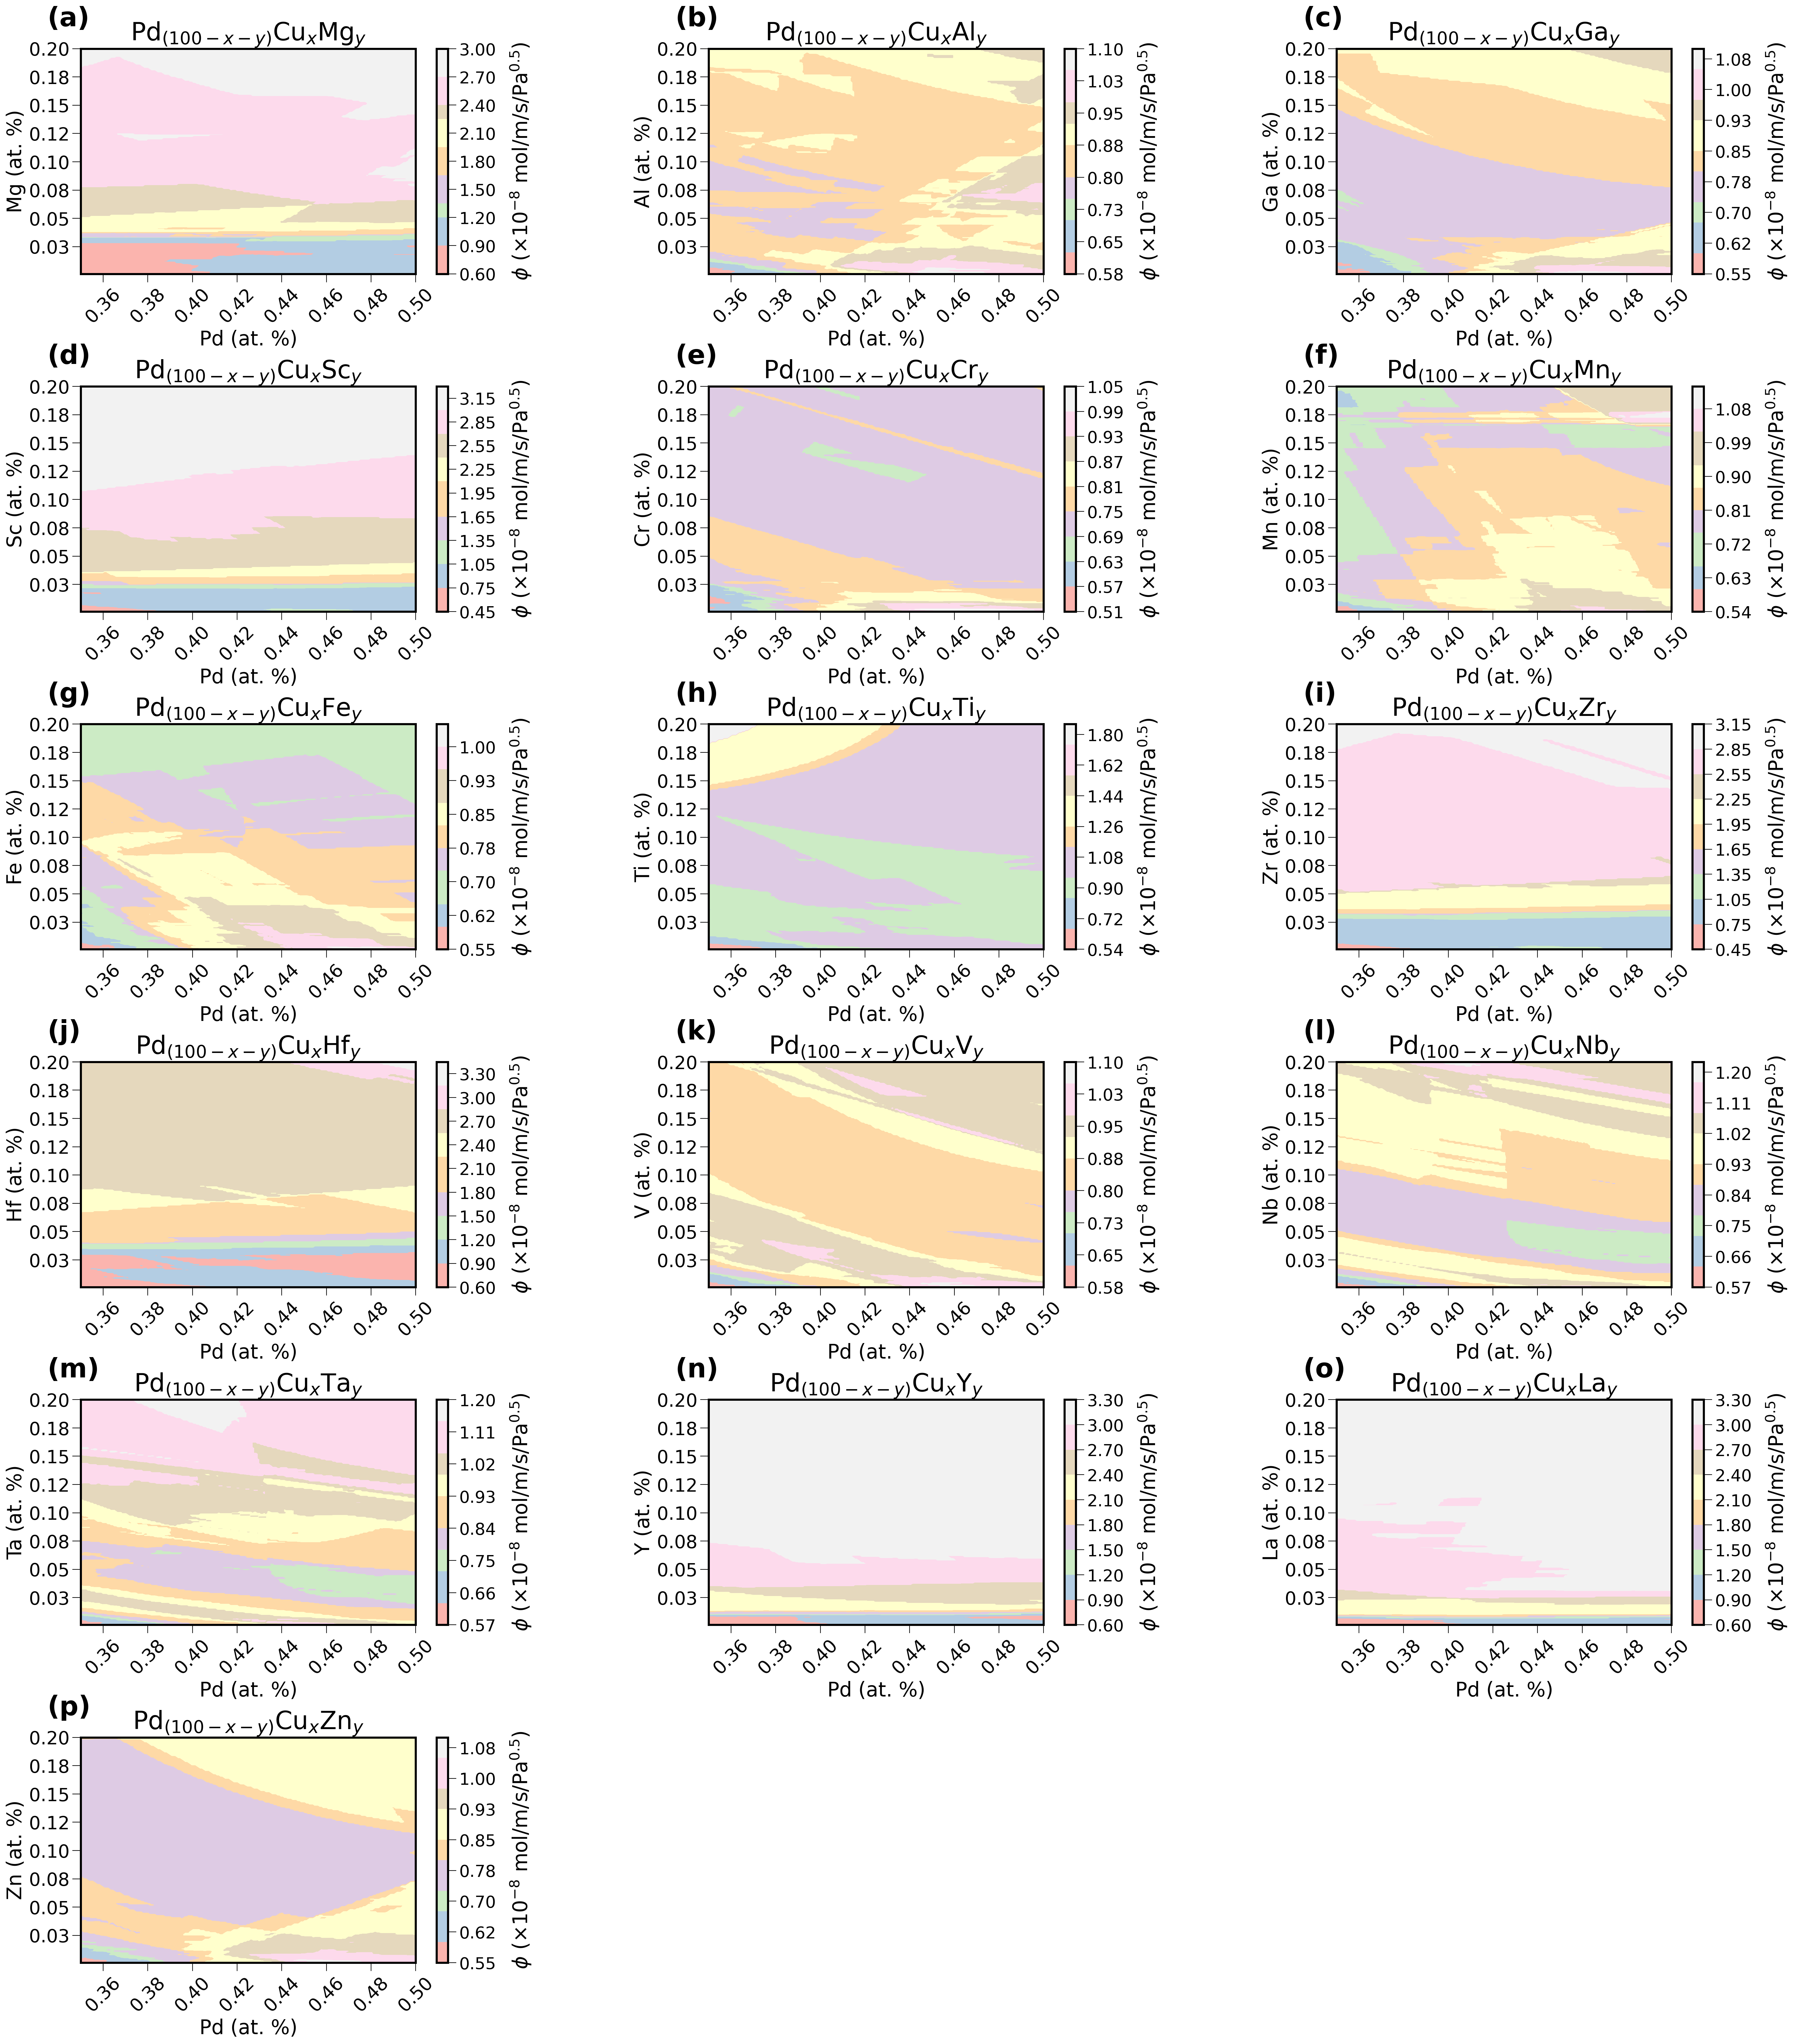

CPU times: user 8.69 s, sys: 773 ms, total: 9.47 s
Wall time: 9.88 s


In [ ]:
%%time
RNG_SEED=42
np.random.seed(RNG_SEED)
# Sketch of how the figure should look like
# {'Mg', 'Al', 'Ga',
#  'Sc', 'Cr', 'Mn',
#  'Fe', 'Ti', 'Zr',
#  'Hf', 'V',  'Nb',
#  'Ta', 'La', 'Y',
#  'Zn'}
from matplotlib.ticker import FormatStrFormatter


PdCuAl_alloys_frame = virtual_alloys_frame_4_plotting[virtual_alloys_frame_4_plotting['Component']=='Pd Cu Al']

PdCuCr_alloys_frame = virtual_alloys_frame_4_plotting[virtual_alloys_frame_4_plotting['Component']=='Pd Cu Cr']

PdCuMn_alloys_frame = virtual_alloys_frame_4_plotting[virtual_alloys_frame_4_plotting['Component']=='Pd Cu Mn']

PdCuFe_alloys_frame = virtual_alloys_frame_4_plotting[virtual_alloys_frame_4_plotting['Component']=='Pd Cu Fe']

PdCuGa_alloys_frame = virtual_alloys_frame_4_plotting[virtual_alloys_frame_4_plotting['Component']=='Pd Cu Ga']

PdCuHf_alloys_frame = virtual_alloys_frame_4_plotting[virtual_alloys_frame_4_plotting['Component']=='Pd Cu Hf']

PdCuLa_alloys_frame = virtual_alloys_frame_4_plotting[virtual_alloys_frame_4_plotting['Component']=='Pd Cu La']

PdCuMg_alloys_frame = virtual_alloys_frame_4_plotting[virtual_alloys_frame_4_plotting['Component']=='Pd Cu Mg']

PdCuNb_alloys_frame = virtual_alloys_frame_4_plotting[virtual_alloys_frame_4_plotting['Component']=='Pd Cu Nb']

PdCuSc_alloys_frame = virtual_alloys_frame_4_plotting[virtual_alloys_frame_4_plotting['Component']=='Pd Cu Sc']

PdCuTa_alloys_frame = virtual_alloys_frame_4_plotting[virtual_alloys_frame_4_plotting['Component']=='Pd Cu Ta']

PdCuTi_alloys_frame = virtual_alloys_frame_4_plotting[virtual_alloys_frame_4_plotting['Component']=='Pd Cu Ti']

PdCuV_alloys_frame = virtual_alloys_frame_4_plotting[virtual_alloys_frame_4_plotting['Component']=='Pd Cu V']

PdCuY_alloys_frame = virtual_alloys_frame_4_plotting[virtual_alloys_frame_4_plotting['Component']=='Pd Cu Y']

PdCuZn_alloys_frame = virtual_alloys_frame_4_plotting[virtual_alloys_frame_4_plotting['Component']=='Pd Cu Zn']

PdCuZr_alloys_frame = virtual_alloys_frame_4_plotting[virtual_alloys_frame_4_plotting['Component']=='Pd Cu Zr']


data_dict= {'PdCuMg': [PdCuMg_alloys_frame, 'Mg'],
            'PdCuAl': [PdCuAl_alloys_frame, 'Al'],
            'PdCuGa': [PdCuGa_alloys_frame, 'Ga'],
            'PdCuSc': [PdCuSc_alloys_frame, 'Sc'],
            'PdCuCr': [PdCuCr_alloys_frame, 'Cr'],
            'PdCuMn': [PdCuMn_alloys_frame, 'Mn'],
            'PdCuFe': [PdCuFe_alloys_frame, 'Fe'],
            'PdCuTi': [PdCuTi_alloys_frame, 'Ti'],
            'PdCuZr': [PdCuZr_alloys_frame, 'Zr'],
            'PdCuHf': [PdCuHf_alloys_frame, 'Hf'],
            'PdCuV':  [PdCuV_alloys_frame,  'V'],
            'PdCuNb': [PdCuNb_alloys_frame, 'Nb'],
            'PdCuTa': [PdCuTa_alloys_frame, 'Ta'],
            'PdCuY':  [PdCuY_alloys_frame,  'Y'],
            'PdCuLa': [PdCuLa_alloys_frame, 'La'],
            'PdCuZn': [PdCuZn_alloys_frame, 'Zn']
            }

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(35, 40))
# Iterate over the items in data_dict directly
for i, (key, value) in enumerate(data_dict.items()):
  ax = axes.ravel()[i]

  # Step 1: get data values
  x = value[0]['Pd'].values
  y = value[0][value[1]].values
  z = value[0]['Predicted_Permeability'].values*1.0e8

  # Step 2: Create a grid (Pd vs M)
  grid_x, grid_y =  np.meshgrid(np.linspace(x.min(), x.max(), num=200),
                                np.linspace(y.min(), y.max(), num=200))

  # Step 3: Interpolate z values onto grid
  grid_z = griddata(
      points=(x, y),
      values=z,
      xi=(grid_x, grid_y),
      method='nearest' #'linear, 'cubic'
  )

  # Step 4: Mask invalid regions where Pd + M >100 (No needed, I am cautious)
  mask = grid_x + grid_y > 100
  grid_z = np.ma.array(grid_z, mask=mask)

  # Step 5: Plot
  cf = ax.contourf(grid_x, grid_y, grid_z, levels=20, cmap='Pastel1')

  # Step 6: Formatting
  cbar = fig.colorbar(cf, ax=ax)
  # cbar.ax.yaxis.set_major_formatter(FuncFormatter(scientific_formatter))

  # Do not show the two last ax
  axes[5, 1].axis('off')
  axes[5, 2].axis('off')

  # Center the axis at axes[5,0]
  # pos = axes[5,0].get_position()
  # new_pos = [0.5, pos.y0, pos.width,pos.height] #0.5, pos.y0, pos.width,pos.height
  # axes[5,0].set_position(new_pos)


  # Formatting
  cbar.set_label(r'$\phi~\mathrm{(\times10^{-8}~mol/m/s/Pa^{0.5})}$', fontsize=24, labelpad=15)
  ax.set_xlabel('Pd (at. %)', fontsize = 24)
  ax.set_ylabel(f'{value[1]} (at. %)', fontsize = 24)

  # Step 7: Increase major tick length on both x and y axes
  ax.tick_params(axis='both', which='major', length=10) # Adjust 'length' as needed
  ax.set_title(r'$\mathrm{Pd}_{(100-x-y)}\mathrm{Cu}_{x}$'+f'{value[1]}'+r'$_{y}$', fontsize = 30)
  # ax.set_title(r'$\mathrm{Cu}_{(100-x-y)}\mathrm{Pd}_{x}$'+f'{value[1]}'+r'$_{y}$', fontsize = 28)

  # Step 8: Increase the spine linewidth
  for spine in ax.spines.values():
    spine.set_linewidth(1.5)

  for spine in cbar.ax.spines.values():
    spine.set_linewidth(1.5)

  # Step 9: Increase xtick and ytick label sizes
  ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=22, rotation=45)
  ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=22)
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  cbar.ax.tick_params(labelsize=20)
  cbar.ax.tick_params(axis='y', which='major', length=10)
  cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  ax.set_aspect('auto')


  # Step 10: Annotate
  ax.text(-0.13, 1.1, f'({string.ascii_uppercase[i]})', transform=ax.transAxes,
            size=32, weight='bold')

  # Save
  # mpl.rcParams['svg.fonttype']='none'
  plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.5, hspace=0.5)
  # fig.savefig(fname='/content/drive/MyDrive/PhD_Pd alloy prediction/Figures_Pd_Permeability_Prediction/contour_map_virtual_alloys_all.svg', bbox_inches='tight', dpi=600, transparent=True)

# fig.tight_layout()
plt.show()

# # Step 1: Assume your data is in df
# x = PdCuY_alloys_frame['Pd'].values
# y = PdCuY_alloys_frame['Y'].values
# z = PdCuY_alloys_frame['Predicted_Permeability'].values

# # Step 2: Create a grid (Pd vs Y)
# grid_x, grid_y = np.meshgrid(np.linspace(x.min(), x.max(), num=200),
#                              np.linspace(y.min(), y.max(), num=200)
# )

# # Step 3: Interpolate z values onto grid
# grid_z = griddata(
#     points=(x, y),
#     values=z,
#     xi=(grid_x, grid_y),
#     method='nearest' #'linear'  # or 'cubic', 'nearest'
# )

# # Step 4: Mask invalid regions where Pd + Y > 100
# mask = grid_x + grid_y > 100
# grid_z = np.ma.array(grid_z, mask=mask)

# # Step 5: Plot
# fig, ax = plt.subplots(figsize=(10, 6))
# cf = ax.contourf(grid_x, grid_y, grid_z, levels=20, cmap='coolwarm')

# # Step 6: Formating
# cbar = fig.colorbar(cf)
# cbar.ax.yaxis.set_major_formatter(FuncFormatter(scientific_formatter))
# cbar.set_label(r'$Predicted~Permeability~\mathrm{(mol/m/s/Pa^{0.5})}$', fontsize=20)
# ax.set_xlabel('Pd (at. %)', fontsize = 22)
# ax.set_ylabel('Y (at. %)', fontsize = 22)

# # Increase major tick length on both x and y axes
# ax.tick_params(axis='both', which='major', length=10) # Adjust 'length' as needed
# ax.set_title(r'$Cu_{(100-x-y)}Pd_{x}Y_{y}$', fontsize = 24)

# Step 7: Save figure
# fig.savefig('/content/drive/MyDrive/PhD_Pd alloy prediction/Figures_Pd_Permeability_Prediction/PdCuY_prez.pdf', dpi=600)
# plt.tight_layout()
# plt.show()


# fig.tight_layout()
# plt.show()

In [ ]:
%%time
# Compute Enthalpy of formation using Miedema paradigm
delta_H_mied = Miedema(struct_types='ss', ss_types='min', data_source='Miedema', impute_nan=False)
virtual_alloys_frame_enthalpy_miedema = delta_H_mied.featurize_dataframe(df=virtual_alloys_frame_4_plotting, col_id='Composition', ignore_errors=True)
virtual_alloys_frame_enthalpy_miedema.to_pickle('/content/drive/MyDrive/PhD_Pd alloy prediction/Virtual_alloys_data/virtual_alloys_frame_enthalpy_miedema.pkl')

Miedema:   0%|          | 0/483200 [00:00<?, ?it/s]

CPU times: user 1min 29s, sys: 14min 43s, total: 16min 13s
Wall time: 16min 2s


In [16]:
%%time
virtual_alloys_frame_enthalpy_miedema=pd.read_pickle('/content/drive/MyDrive/PhD_Pd alloy prediction/Virtual_alloys_data/virtual_alloys_frame_enthalpy_miedema.pkl')
virtual_alloys_frame_enthalpy_miedema.head(100)

CPU times: user 3.46 s, sys: 625 ms, total: 4.08 s
Wall time: 5.08 s


Virtual_alloys   Composition  lattice_param  Δa_ss/a_Pd  \
0    Pd35.0Cu64.9Mg0.1  (Pd, Cu, Mg)   2.901422e-10    -0.25415   
1    Pd35.0Cu64.8Mg0.2  (Pd, Cu, Mg)   2.902294e-10    -0.25393   
2    Pd35.0Cu64.7Mg0.3  (Pd, Cu, Mg)   2.903165e-10    -0.25370   
3    Pd35.0Cu64.6Mg0.4  (Pd, Cu, Mg)   2.904038e-10    -0.25348   
4    Pd35.0Cu64.5Mg0.5  (Pd, Cu, Mg)   2.904909e-10    -0.25326   
5    Pd35.0Cu64.4Mg0.6  (Pd, Cu, Mg)   2.905782e-10    -0.25303   
6    Pd35.0Cu64.3Mg0.7  (Pd, Cu, Mg)   2.906653e-10    -0.25281   
7    Pd35.0Cu64.2Mg0.8  (Pd, Cu, Mg)   2.907525e-10    -0.25258   
8    Pd35.0Cu64.1Mg0.9  (Pd, Cu, Mg)   2.908398e-10    -0.25236   
9    Pd35.0Cu64.0Mg1.0  (Pd, Cu, Mg)   2.909270e-10    -0.25214   
10   Pd35.0Cu63.9Mg1.1  (Pd, Cu, Mg)   2.910141e-10    -0.25191   
11   Pd35.0Cu63.8Mg1.2  (Pd, Cu, Mg)   2.911014e-10    -0.25169   
12   Pd35.0Cu63.7Mg1.3  (Pd, Cu, Mg)   2.911886e-10    -0.25146   
13   Pd35.0Cu63.6Mg1.4  (Pd, Cu, Mg)   2.912758e-10    -0.25124   
14   Pd35.0Cu63.5Mg1.5  (Pd, Cu, Mg)   2.913629e-10    -0.25101   
15   Pd35.0Cu63.4Mg1.6  (Pd, Cu, Mg)   2.914502e-10    -0.25079   
16   Pd35.0Cu63.3Mg1.7  (Pd, Cu, Mg)   2.915373e-10    -0.25057   
17   Pd35.0Cu63.2Mg1.8  (Pd, Cu, Mg)   2.916246e-10    -0.25034   
18   Pd35.0Cu63.1Mg1.9  (Pd, Cu, Mg)   2.917117e-10    -0.25012   
19   Pd35.0Cu63.0Mg2.0  (Pd, Cu, Mg)   2.917989e-10    -0.24989   
20   Pd35.0Cu62.9Mg2.1  (Pd, Cu, Mg)   2.918862e-10    -0.24967   
21   Pd35.0Cu62.8Mg2.2  (Pd, Cu, Mg)   2.919734e-10    -0.24945   
22   Pd35.0Cu62.7Mg2.3  (Pd, Cu, Mg)   2.920605e-10    -0.24922   
23   Pd35.0Cu62.6Mg2.4  (Pd, Cu, Mg)   2.921478e-10    -0.24900   
24   Pd35.0Cu62.5Mg2.5  (Pd, Cu, Mg)   2.922349e-10    -0.24877   
25   Pd35.0Cu62.4Mg2.6  (Pd, Cu, Mg)   2.923221e-10    -0.24855   
26   Pd35.0Cu62.3Mg2.7  (Pd, Cu, Mg)   2.924093e-10    -0.24833   
27   Pd35.0Cu62.2Mg2.8  (Pd, Cu, Mg)   2.924966e-10    -0.24810   
28   Pd35.0Cu62.1Mg2.9  (Pd, Cu, Mg)   2.925837e-10    -0.24788   
29   Pd35.0Cu62.0Mg3.0  (Pd, Cu, Mg)   2.926709e-10    -0.24765   
30   Pd35.0Cu61.9Mg3.1  (Pd, Cu, Mg)   2.927581e-10    -0.24743   
31   Pd35.0Cu61.8Mg3.2  (Pd, Cu, Mg)   2.928453e-10    -0.24720   
32   Pd35.0Cu61.7Mg3.3  (Pd, Cu, Mg)   2.929326e-10    -0.24698   
33   Pd35.0Cu61.6Mg3.4  (Pd, Cu, Mg)   2.930198e-10    -0.24676   
34   Pd35.0Cu61.5Mg3.5  (Pd, Cu, Mg)   2.931069e-10    -0.24653   
35   Pd35.0Cu61.4Mg3.6  (Pd, Cu, Mg)   2.931941e-10    -0.24631   
36   Pd35.0Cu61.3Mg3.7  (Pd, Cu, Mg)   2.932814e-10    -0.24608   
37   Pd35.0Cu61.2Mg3.8  (Pd, Cu, Mg)   2.933685e-10    -0.24586   
38   Pd35.0Cu61.1Mg3.9  (Pd, Cu, Mg)   2.934557e-10    -0.24564   
39   Pd35.0Cu61.0Mg4.0  (Pd, Cu, Mg)   2.935429e-10    -0.24541   
40   Pd35.0Cu60.9Mg4.1  (Pd, Cu, Mg)   2.936301e-10    -0.24519   
41   Pd35.0Cu60.8Mg4.2  (Pd, Cu, Mg)   2.937174e-10    -0.24496   
42   Pd35.0Cu60.7Mg4.3  (Pd, Cu, Mg)   2.938045e-10    -0.24474   
43   Pd35.0Cu60.6Mg4.4  (Pd, Cu, Mg)   2.938917e-10    -0.24451   
44   Pd35.0Cu60.5Mg4.5  (Pd, Cu, Mg)   2.939789e-10    -0.24429   
45   Pd35.0Cu60.4Mg4.6  (Pd, Cu, Mg)   2.940662e-10    -0.24407   
46   Pd35.0Cu60.3Mg4.7  (Pd, Cu, Mg)   2.941534e-10    -0.24384   
47   Pd35.0Cu60.2Mg4.8  (Pd, Cu, Mg)   2.942405e-10    -0.24362   
48   Pd35.0Cu60.1Mg4.9  (Pd, Cu, Mg)   2.943278e-10    -0.24339   
49   Pd35.0Cu60.0Mg5.0  (Pd, Cu, Mg)   2.944149e-10    -0.24317   
50   Pd35.0Cu59.9Mg5.1  (Pd, Cu, Mg)   2.945021e-10    -0.24295   
51   Pd35.0Cu59.8Mg5.2  (Pd, Cu, Mg)   2.945893e-10    -0.24272   
52   Pd35.0Cu59.7Mg5.3  (Pd, Cu, Mg)   2.946766e-10    -0.24250   
53   Pd35.0Cu59.6Mg5.4  (Pd, Cu, Mg)   2.947637e-10    -0.24227   
54   Pd35.0Cu59.5Mg5.5  (Pd, Cu, Mg)   2.948509e-10    -0.24205   
55   Pd35.0Cu59.4Mg5.6  (Pd, Cu, Mg)   2.949381e-10    -0.24182   
56   Pd35.0Cu59.3Mg5.7  (Pd, Cu, Mg)   2.950253e-10    -0.24160   
57   Pd35.0Cu59.2Mg5.8  (Pd, Cu, Mg)   2.951126e-10    -0.24138   
58   Pd35.0Cu59.1Mg5.9  (Pd, Cu, Mg)   2.951997e-10    

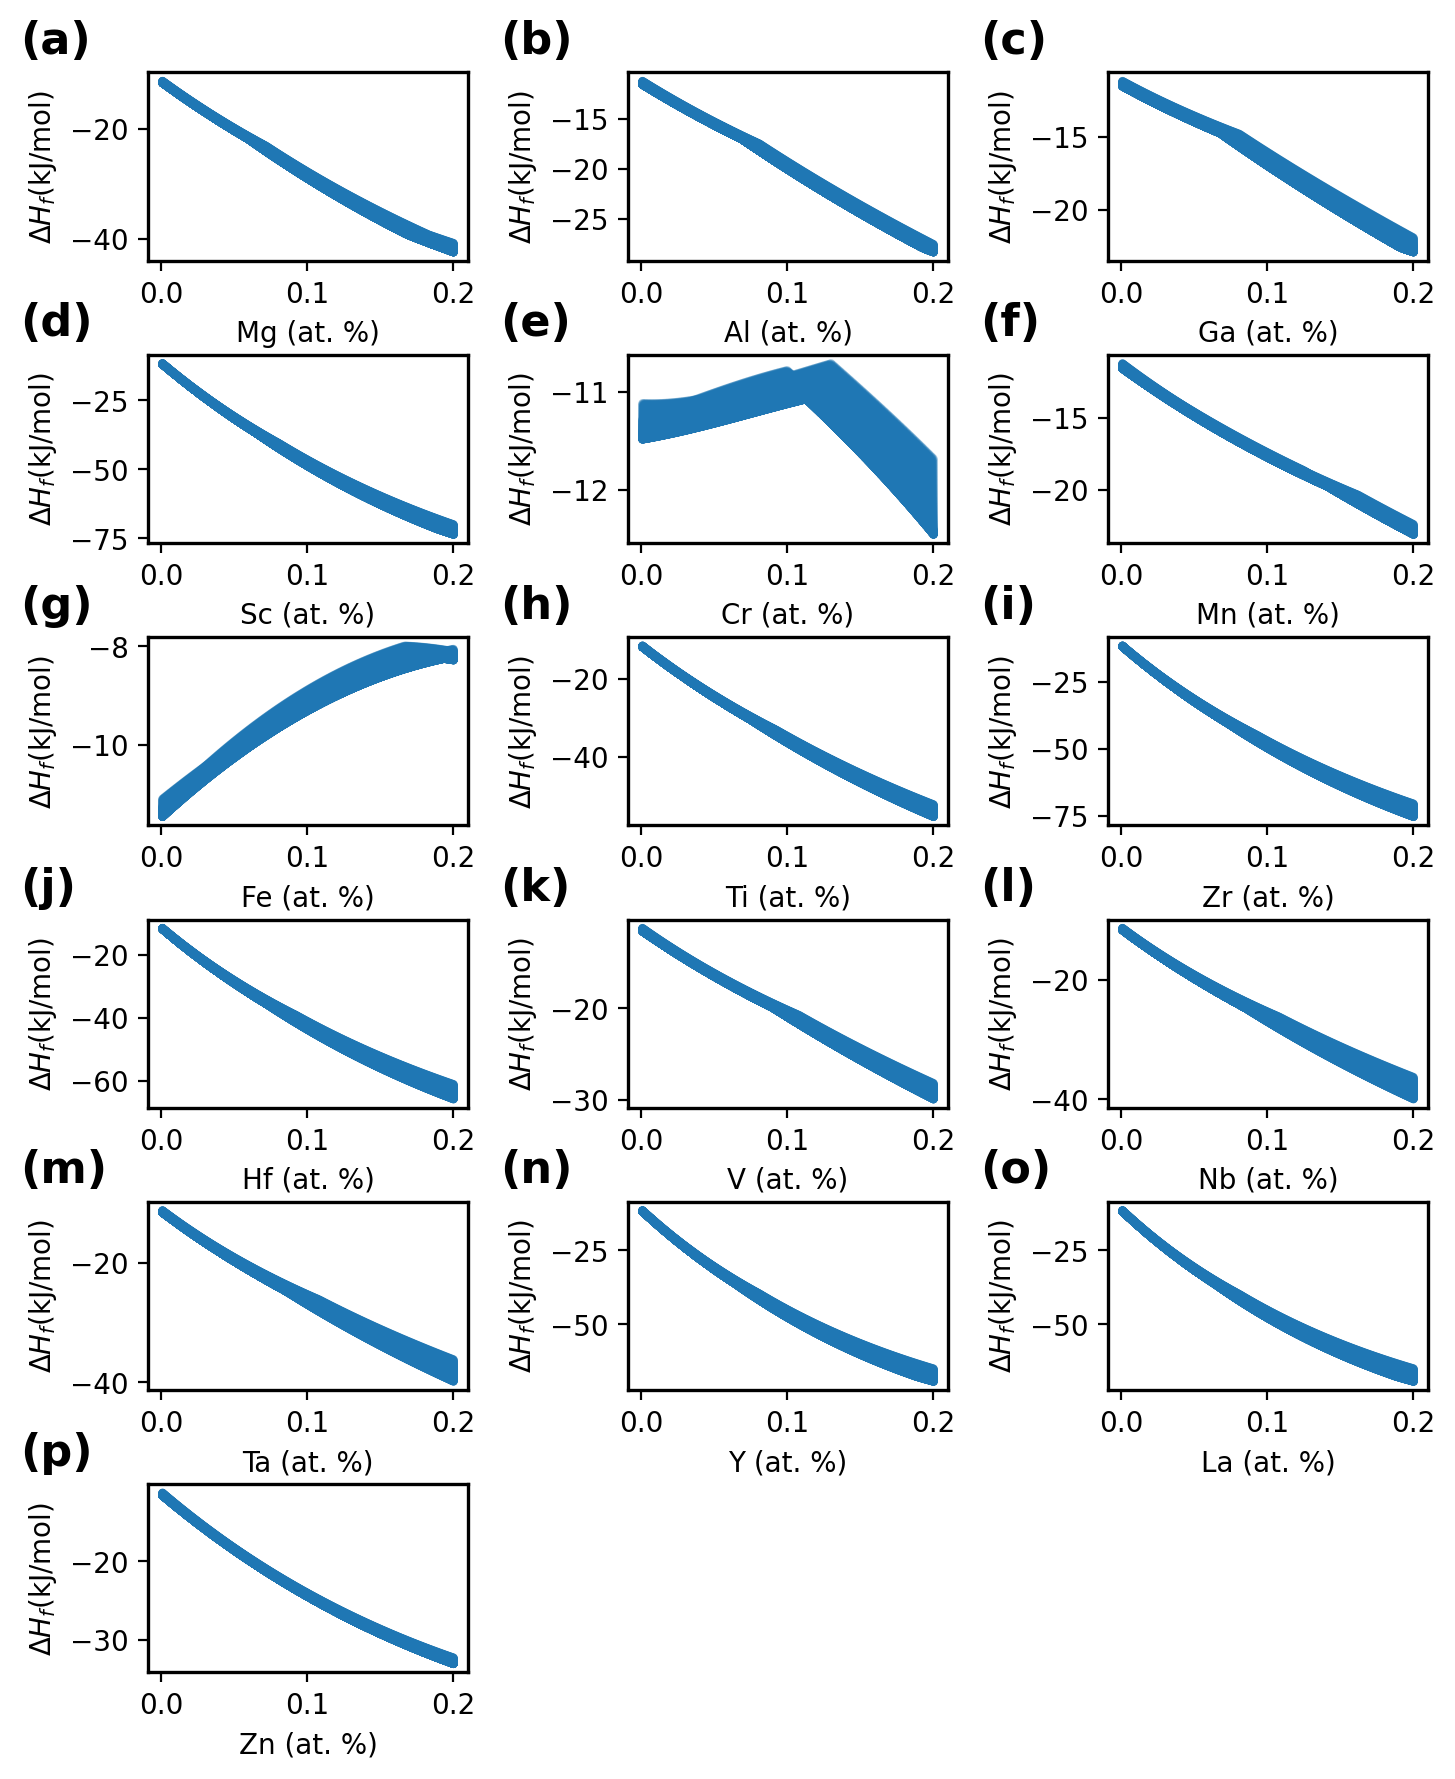

CPU times: user 53.3 s, sys: 342 ms, total: 53.6 s
Wall time: 56.2 s


In [36]:
%%time
# List
PdCuAl_alloys_frame = virtual_alloys_frame_enthalpy_miedema[virtual_alloys_frame_enthalpy_miedema['Component']=='Pd Cu Al']

PdCuCr_alloys_frame = virtual_alloys_frame_enthalpy_miedema[virtual_alloys_frame_enthalpy_miedema['Component']=='Pd Cu Cr']

PdCuMn_alloys_frame = virtual_alloys_frame_enthalpy_miedema[virtual_alloys_frame_enthalpy_miedema['Component']=='Pd Cu Mn']

PdCuFe_alloys_frame = virtual_alloys_frame_enthalpy_miedema[virtual_alloys_frame_enthalpy_miedema['Component']=='Pd Cu Fe']

PdCuGa_alloys_frame = virtual_alloys_frame_enthalpy_miedema[virtual_alloys_frame_enthalpy_miedema['Component']=='Pd Cu Ga']

PdCuHf_alloys_frame = virtual_alloys_frame_enthalpy_miedema[virtual_alloys_frame_enthalpy_miedema['Component']=='Pd Cu Hf']

PdCuLa_alloys_frame = virtual_alloys_frame_enthalpy_miedema[virtual_alloys_frame_enthalpy_miedema['Component']=='Pd Cu La']

PdCuMg_alloys_frame = virtual_alloys_frame_enthalpy_miedema[virtual_alloys_frame_enthalpy_miedema['Component']=='Pd Cu Mg']

PdCuNb_alloys_frame = virtual_alloys_frame_enthalpy_miedema[virtual_alloys_frame_enthalpy_miedema['Component']=='Pd Cu Nb']

PdCuSc_alloys_frame = virtual_alloys_frame_enthalpy_miedema[virtual_alloys_frame_enthalpy_miedema['Component']=='Pd Cu Sc']

PdCuTa_alloys_frame = virtual_alloys_frame_enthalpy_miedema[virtual_alloys_frame_enthalpy_miedema['Component']=='Pd Cu Ta']

PdCuTi_alloys_frame = virtual_alloys_frame_enthalpy_miedema[virtual_alloys_frame_enthalpy_miedema['Component']=='Pd Cu Ti']

PdCuV_alloys_frame = virtual_alloys_frame_enthalpy_miedema[virtual_alloys_frame_enthalpy_miedema['Component']=='Pd Cu V']

PdCuY_alloys_frame = virtual_alloys_frame_enthalpy_miedema[virtual_alloys_frame_enthalpy_miedema['Component']=='Pd Cu Y']

PdCuZn_alloys_frame = virtual_alloys_frame_enthalpy_miedema[virtual_alloys_frame_enthalpy_miedema['Component']=='Pd Cu Zn']

PdCuZr_alloys_frame = virtual_alloys_frame_enthalpy_miedema[virtual_alloys_frame_enthalpy_miedema['Component']=='Pd Cu Zr']


data_dict= {'PdCuMg': [PdCuMg_alloys_frame, 'Mg'],
            'PdCuAl': [PdCuAl_alloys_frame, 'Al'],
            'PdCuGa': [PdCuGa_alloys_frame, 'Ga'],
            'PdCuSc': [PdCuSc_alloys_frame, 'Sc'],
            'PdCuCr': [PdCuCr_alloys_frame, 'Cr'],
            'PdCuMn': [PdCuMn_alloys_frame, 'Mn'],
            'PdCuFe': [PdCuFe_alloys_frame, 'Fe'],
            'PdCuTi': [PdCuTi_alloys_frame, 'Ti'],
            'PdCuZr': [PdCuZr_alloys_frame, 'Zr'],
            'PdCuHf': [PdCuHf_alloys_frame, 'Hf'],
            'PdCuV':  [PdCuV_alloys_frame,  'V'],
            'PdCuNb': [PdCuNb_alloys_frame, 'Nb'],
            'PdCuTa': [PdCuTa_alloys_frame, 'Ta'],
            'PdCuY':  [PdCuY_alloys_frame,  'Y'],
            'PdCuLa': [PdCuLa_alloys_frame, 'La'],
            'PdCuZn': [PdCuZn_alloys_frame, 'Zn']
            }

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(8,10))
# Iterate over the items in data_dict directly
for i, (key, value) in enumerate(data_dict.items()):
  ax = axes.ravel()[i]

  # Step 1: get data values
  x = value[0][value[1]].values
  y = value[0]['Miedema_deltaH_ss_min'].values*96.4853
  pts = ax.scatter(x, y, s=9, edgecolors='none', alpha=0.35)
  pts.set_rasterized(True)
  ax.set_xlabel(f'{value[1]} (at. %)')
  ax.set_ylabel('$\Delta H_{f} \mathrm{(kJ/mol)}$')

  # Step 8: Increase the spine linewidth
  for spine in ax.spines.values():
    spine.set_linewidth(1.2)

  # Step 9: Annotate
  ax.text(-0.40, 1.1, f'({string.ascii_lowercase[i]})', transform=ax.transAxes,
          size=16, weight='bold')

# Step 10: Turn off any unused subplots
for j in range(i + 1, len(axes.ravel())):
    axes.ravel()[j].axis('off')


# Save
mpl.rcParams['svg.fonttype']='none'
fig.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.5, hspace=0.5)
fig.savefig(fname='/content/drive/MyDrive/PhD_Pd alloy prediction/Figures_Pd_Permeability_Prediction/Delta_H_form_virtual_alloys.svg', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

In [ ]:
%%time
# PdCuAl_alloys_frame = virtual_alloys_frame_enthalpy_miedema[virtual_alloys_frame_enthalpy_miedema['Component']=='Pd Cu Al']
# Examination_frame = virtual_alloys_frame_enthalpy_miedema[['Virtual_alloys', 'Pd', 'Predicted_Permeability', 'Miedema_deltaH_ss_min']]
# mask = paretoset(Examination_frame, sense=["min", "max", 'min'])
# paretoset_alloys = Examination_frame[mask]

data_dict= {'PdCuMg': PdCuMg_alloys_frame,
            'PdCuAl': PdCuAl_alloys_frame,
            'PdCuGa': PdCuGa_alloys_frame,
            'PdCuSc': PdCuSc_alloys_frame,
            'PdCuCr': PdCuCr_alloys_frame,
            'PdCuFe': PdCuFe_alloys_frame,
            'PdCuTi': PdCuTi_alloys_frame,
            'PdCuZr': PdCuZr_alloys_frame,
            'PdCuHf': PdCuHf_alloys_frame,
            'PdCuV':  PdCuV_alloys_frame,
            'PdCuNb': PdCuNb_alloys_frame,
            'PdCuTa': PdCuTa_alloys_frame,
            'PdCuY':  PdCuY_alloys_frame,
            'PdCuLa': PdCuLa_alloys_frame,
            'PdCuZn': PdCuZn_alloys_frame,
            }

non_dominated_summary = {}
for system, df_sys in data_dict.items():
    mask = paretoset(df_sys[['Pd','Predicted_Permeability','Miedema_deltaH_ss_min']],
                     sense=['min','max','min'])
    efficient = df_sys.loc[mask].copy()
    non_dominated_summary[f'non_dominated_{system}'] = [efficient, efficient.index.tolist()]

all_index = [i for _, (_, idxs) in non_dominated_summary.items() for i in idxs]
Promising_candidate = virtual_alloys_frame_enthalpy_miedema.loc[all_index]

CPU times: user 1.64 s, sys: 100 ms, total: 1.74 s
Wall time: 1.93 s


In [ ]:
%%time
# For every system I will chose:
# The alloy with highest permeability,
# The alloy with smallest enthalpy of formation
# The alloy with smallest Pd content

# columns needed: Component, Predicted_Permeability, Pd, Miedema_deltaH_ss_min
final_rows = []

for system in Promising_candidate['Component'].unique():
    current = Promising_candidate.loc[Promising_candidate['Component'] == system]\
                                 .dropna(subset=['Predicted_Permeability','Pd','Miedema_deltaH_ss_min'])

    best_perm   = current.loc[[current['Predicted_Permeability'].idxmax()]].assign(selection='max_perm')
    smallest_Pd = current.loc[[current['Pd'].idxmin()]].assign(selection='min_Pd')
    smallest_H  = current.loc[[current['Miedema_deltaH_ss_min'].idxmin()]].assign(selection='min_dH')

    final_rows += [best_perm, smallest_Pd, smallest_H]

final_result_frame = pd.concat(final_rows, ignore_index=True)

# Optional: if the same alloy wins multiple criteria, keep one row per alloy/system
if 'virtual alloys' in final_result_frame.columns:
    final_result_frame = final_result_frame.drop_duplicates(subset=['Component','virtual alloys'])

CPU times: user 56.1 ms, sys: 80 µs, total: 56.2 ms
Wall time: 55.4 ms


In [ ]:
final_result_frame

Virtual_alloys   Composition  lattice_param  Δa_ss/a_Pd  \
0   Pd35.9Cu44.1Mg20.0  (Pd, Cu, Mg)   3.074964e-10    -0.20954   
1   Pd35.0Cu45.0Mg20.0  (Pd, Cu, Mg)   3.074949e-10    -0.20955   
2   Pd48.0Cu32.0Mg20.0  (Pd, Cu, Mg)   3.075154e-10    -0.20949   
3    Pd47.0Cu52.9Al0.1  (Pd, Cu, Al)   2.901887e-10    -0.25403   
4   Pd35.0Cu45.0Al20.0  (Pd, Cu, Al)   3.130442e-10    -0.19528   
5   Pd44.3Cu35.7Al20.0  (Pd, Cu, Al)   3.130588e-10    -0.19524   
6    Pd46.9Cu53.0Ga0.1  (Pd, Cu, Ga)   2.903226e-10    -0.25369   
7   Pd35.0Cu47.6Ga17.4  (Pd, Cu, Ga)   3.333803e-10    -0.14300   
8   Pd45.8Cu34.2Ga20.0  (Pd, Cu, Ga)   3.398712e-10    -0.12632   
9   Pd35.0Cu50.7Sc14.3  (Pd, Cu, Sc)   3.039672e-10    -0.21861   
10  Pd35.0Cu50.7Sc14.3  (Pd, Cu, Sc)   3.039672e-10    -0.21861   
11  Pd50.0Cu30.0Sc20.0  (Pd, Cu, Sc)   3.095362e-10    -0.20430   
12   Pd47.6Cu52.3Cr0.1  (Pd, Cu, Cr)   2.900732e-10    -0.25433   
13   Pd35.0Cu61.9Cr3.1  (Pd, Cu, Cr)   2.900078e-10    -0.25450   
14  Pd46.7Cu33.3Cr20.0  (Pd, Cu, Cr)   2.897693e-10    -0.25511   
15   Pd48.2Cu51.7Fe0.1  (Pd, Cu, Fe)   2.900723e-10    -0.25433   
16   Pd35.0Cu64.9Fe0.1  (Pd, Cu, Fe)   2.900516e-10    -0.25439   
17   Pd43.4Cu56.5Fe0.1  (Pd, Cu, Fe)   2.900648e-10    -0.25435   
18  Pd35.0Cu45.0Ti20.0  (Pd, Cu, Ti)   3.008887e-10    -0.22653   
19  Pd35.0Cu45.0Ti20.0  (Pd, Cu, Ti)   3.008887e-10    -0.22653   
20  Pd50.0Cu30.0Ti20.0  (Pd, Cu, Ti)   3.009122e-10    -0.22647   
21  Pd35.9Cu44.1Zr20.0  (Pd, Cu, Zr)   3.075324e-10    -0.20945   
22  Pd35.0Cu45.0Zr20.0  (Pd, Cu, Zr)   3.075310e-10    -0.20945   
23  Pd50.0Cu30.0Zr20.0  (Pd, Cu, Zr)   3.075545e-10    -0.20939   
24  Pd49.6Cu30.4Hf20.0  (Pd, Cu, Hf)   3.065111e-10    -0.21207   
25  Pd35.0Cu45.5Hf19.5  (Pd, Cu, Hf)   3.060773e-10    -0.21319   
26  Pd50.0Cu30.0Hf20.0  (Pd, Cu, Hf)   3.065117e-10    -0.21207   
27    Pd46.0Cu53.9V0.1   (Pd, Cu, V)   2.900846e-10    -0.25430   
28    Pd35.0Cu57.4V7.6   (Pd, Cu, V)   2.909974e-10    -0.25195   
29   Pd50.0Cu30.0V20.0   (Pd, Cu, V)   2.925585e-10    -0.24794   
30  Pd40.4Cu39.6Nb20.0  (Pd, Cu, Nb)   2.980714e-10    -0.23377   
31  Pd35.0Cu45.2Nb19.8  (Pd, Cu, Nb)   2.979829e-10    -0.23400   
32  Pd50.0Cu30.0Nb20.0  (Pd, Cu, Nb)   2.980865e-10    -0.23373   
33  Pd39.5Cu40.6Ta19.9  (Pd, Cu, Ta)   2.980817e-10    -0.23374   
34  Pd35.0Cu49.1Ta15.9  (Pd, Cu, Ta)   2.964626e-10    -0.23791   
35  Pd50.0Cu30.0Ta20.0  (Pd, Cu, Ta)   2.981385e-10    -0.23360   
36    Pd37.1Cu55.1Y7.8   (Pd, Cu, Y)   3.077535e-10    -0.20888   
37   Pd35.0Cu54.9Y10.1   (Pd, Cu, Y)   3.129680e-10    -0.19548   
38   Pd50.0Cu30.0Y20.0   (Pd, Cu, Y)   3.354509e-10    -0.13768   
39   Pd46.6Cu46.9La6.5  (Pd, Cu, La)   3.056451e-10    -0.21430   
40  Pd35.0Cu45.0La20.0  (Pd, Cu, La)   3.379685e-10    -0.13121   
41  Pd50.0Cu30.0La20.0  (Pd, Cu, La)   3.379920e-10    -0.13115   
42   Pd47.1Cu52.8Zn0.1  (Pd, Cu, Zn)   2.901115e-10    -0.25423   
43   Pd35.0Cu59.6Zn5.4  (Pd, Cu, Zn)   2.920805e-10    -0.24917   
44  Pd44.4Cu35.6Zn20.0  (Pd, Cu, Zn)   2.975718e-10    -0.23505   

    No of Components Component Moles of individual Components  Total Moles  \
0                  3  Pd Cu Mg                 35.9 44.1 20.0        100.0   
1                  3  Pd Cu Mg                 35.0 45.0 20.0        100.0   
2                  3  Pd Cu Mg                 48.0 32.0 20.0        100.0   
3                  3  Pd Cu Al                  47.0 52.9 0.1        100.0   
4                  3  Pd Cu Al                 35.0 45.0 20.0        100.0   
5                  3  Pd Cu Al                 44.3 35.7 20.0        100.0   
6                  3  Pd Cu Ga                  46.9 53.0 0.1        100.0   
7                  3  Pd Cu Ga                 35.0 47.6 17.4        100.0   
8                  3  Pd Cu Ga                 45.8 34.2 20.0        100.0   
9                  3  Pd Cu Sc                 35.0 50.7 14.3        100.0   
10                 3  Pd Cu Sc                 35.0 50.7 14.3      

## Virtual alloys screening with edge case Cu=50 at% fixed

In [ ]:
%%time
# Virtual ternary alloys generator function
def generate_virtual_Cu50_Pd_M(elments:list,
                               order="CuPdM"):
  # x = Pd in 0.1 at% units: 35.0..50.0  -> 350..500
  # y = M  in 0.1 at% units:  0.1..20.0  ->   1..200
  # z= Cu= 50 at% fixed
  for M in elements:
    for xi in range(350, 500+1):
      x = xi/10.0 # Pd
      y = (500-xi)/10.0 # M
      z = 50 # Cu
      if y==0:
        continue

      assert x+y+z==100, "Condition violated, please verify x, y, z"

      if order=='CuPdM':
        yield f"Cu{z:.1f}Pd{x:.1f}{M}{y:.1f}"
      else:
        yield f"Pd{x:.1f}Cu{z:.1f}{M}{y:.1f}"


# def generate_virtual_Cu50_Pd_M(elements:list,
#                                interval:np.number,
#                                order="CuPdM"):
#   # x = Pd in 0.1 at% units: 35.0..50.0  -> 350..500
#   # y = M  in 0.1 at% units:  0.1..20.0  ->   1..200
#   # z= Cu= 50 at% fixed
#   for M in elements:
#     start_1=35
#     stop_1=50
#     interval=interval
#     num_1=round((stop_1-start_1)/interval+1)
#     for xi in np.linspace(start=start_1, stop=stop_1, num=num_1):
#       x = xi # Pd
#       y = np.subtract(50.00, xi) # M
#       z = 50 # Cu
#       if y==0:
#         continue
#       assert x+y+z==100, "Condition violated, please verify x, y, z"

#       if order=='CuPdM':
#         yield f"Cu{z:.2f}Pd{x:2f}{M}{y:.2f}"
#       else:
#         yield f"Pd{x:.2f}Cu{z:.2f}{M}{y:.2f}"

# Application of the function
elements = ['Mg', 'Al', 'Sc', 'Ti', 'V', 'Cr', 'Fe', 'Zn', 'Ga', 'Y', 'Zr', 'Nb', 'La', 'Hf', 'Ta']
virtual_alloys_Cu_fixed = list(generate_virtual_Cu50_Pd_M(elements, order="PdCuM"))

CPU times: user 2.16 ms, sys: 0 ns, total: 2.16 ms
Wall time: 2.16 ms


In [ ]:
%%time
# Print the size of the list generated
print('The number of virtual alloys generated is:', len(virtual_alloys_Cu_fixed))

The number of virtual alloys generated is: 2250
CPU times: user 42 µs, sys: 0 ns, total: 42 µs
Wall time: 45.5 µs


In [ ]:
%%time
# Create a dataframe of virtual_alloys_Cu_fixed
virtual_alloys_Cu_fixed_frame = pd.DataFrame({
      'Virtual_alloys':virtual_alloys_Cu_fixed,
      'Composition': [Composition(i) for i in virtual_alloys_Cu_fixed],
})
virtual_alloys_Cu_fixed_frame.head(5)

CPU times: user 21.1 ms, sys: 0 ns, total: 21.1 ms
Wall time: 20.9 ms


Virtual_alloys   Composition
0  Pd35.0Cu50.0Mg15.0  (Pd, Cu, Mg)
1  Pd35.1Cu50.0Mg14.9  (Pd, Cu, Mg)
2  Pd35.2Cu50.0Mg14.8  (Pd, Cu, Mg)
3  Pd35.3Cu50.0Mg14.7  (Pd, Cu, Mg)
4  Pd35.4Cu50.0Mg14.6  (Pd, Cu, Mg)

In [ ]:
%%time
# Creating the lattice paramters
virtual_alloys_Cu_fixed_frame['lattice_param'] = virtual_alloys_Cu_fixed_frame['Composition'].apply(ternary_alloy_lattice_param_calculator)
virtual_alloys_Cu_fixed_frame['lattice_param'] = virtual_alloys_Cu_fixed_frame['lattice_param'].apply(lambda x: x*1e-10)
virtual_alloys_Cu_fixed_frame.head()

CPU times: user 21.2 ms, sys: 0 ns, total: 21.2 ms
Wall time: 20.8 ms


Virtual_alloys   Composition  lattice_param
0  Pd35.0Cu50.0Mg15.0  (Pd, Cu, Mg)   3.031349e-10
1  Pd35.1Cu50.0Mg14.9  (Pd, Cu, Mg)   3.030479e-10
2  Pd35.2Cu50.0Mg14.8  (Pd, Cu, Mg)   3.029609e-10
3  Pd35.3Cu50.0Mg14.7  (Pd, Cu, Mg)   3.028738e-10
4  Pd35.4Cu50.0Mg14.6  (Pd, Cu, Mg)   3.027868e-10

In [ ]:
%%time
# Creating the lattice mismatch
virtual_alloys_Cu_fixed_frame['Δa_ss/a_Pd'] = virtual_alloys_Cu_fixed_frame['lattice_param'].apply(lambda x: round(((x-3.8901037037037046e-10)/3.8901037037037046e-10), 5))
virtual_alloys_Cu_fixed_frame.head()

CPU times: user 2.18 ms, sys: 0 ns, total: 2.18 ms
Wall time: 2.15 ms


Virtual_alloys   Composition  lattice_param  Δa_ss/a_Pd
0  Pd35.0Cu50.0Mg15.0  (Pd, Cu, Mg)   3.031349e-10    -0.22075
1  Pd35.1Cu50.0Mg14.9  (Pd, Cu, Mg)   3.030479e-10    -0.22098
2  Pd35.2Cu50.0Mg14.8  (Pd, Cu, Mg)   3.029609e-10    -0.22120
3  Pd35.3Cu50.0Mg14.7  (Pd, Cu, Mg)   3.028738e-10    -0.22142
4  Pd35.4Cu50.0Mg14.6  (Pd, Cu, Mg)   3.027868e-10    -0.22165

In [ ]:
%%time
# Featurize the dataframe
composition_matrix = virtual_alloys_Cu_fixed_frame['Composition']

#%%
bond_properties = Alloy_Featurizer(composition_matrix)

CPU times: user 10.1 s, sys: 82.3 ms, total: 10.2 s
Wall time: 10.2 s


In [ ]:
%%time
# Concatenatte the dataframes and save the files
virtual_alloys_Cu50_fixed = pd.concat([virtual_alloys_Cu_fixed_frame, bond_properties], axis=1)

CPU times: user 1.09 ms, sys: 0 ns, total: 1.09 ms
Wall time: 1.03 ms


In [ ]:
%%time
# Show
# 'Pressure difference' ---> 131.0Pa^0.5
#  'Thickness'--> 15 micron *1e6 -->m
#  'Temperature' ---> 673.15
to_transform = ['Pressure difference', 'Thickness', 'Temperature']
virtual_alloys_Cu50_fixed['Pressure difference'] = 131.0   # Pa^0.5
virtual_alloys_Cu50_fixed['Thickness'] = 15.0*1.0e-6       # m
virtual_alloys_Cu50_fixed['Temperature'] = 673.15          # K

CPU times: user 960 µs, sys: 3 µs, total: 963 µs
Wall time: 898 µs


In [ ]:
%%time
# Visualizing
virtual_alloys_Cu50_fixed.head()

CPU times: user 211 µs, sys: 0 ns, total: 211 µs
Wall time: 215 µs


Virtual_alloys   Composition  lattice_param  Δa_ss/a_Pd  \
0  Pd35.0Cu50.0Mg15.0  (Pd, Cu, Mg)   3.031349e-10    -0.22075   
1  Pd35.1Cu50.0Mg14.9  (Pd, Cu, Mg)   3.030479e-10    -0.22098   
2  Pd35.2Cu50.0Mg14.8  (Pd, Cu, Mg)   3.029609e-10    -0.22120   
3  Pd35.3Cu50.0Mg14.7  (Pd, Cu, Mg)   3.028738e-10    -0.22142   
4  Pd35.4Cu50.0Mg14.6  (Pd, Cu, Mg)   3.027868e-10    -0.22165   

   No of Components Component Moles of individual Components  Total Moles  \
0                 3  Pd Cu Mg                 35.0 50.0 15.0        100.0   
1                 3  Pd Cu Mg                 35.1 50.0 14.9        100.0   
2                 3  Pd Cu Mg                 35.2 50.0 14.8        100.0   
3                 3  Pd Cu Mg                 35.3 50.0 14.7        100.0   
4                 3  Pd Cu Mg                 35.4 50.0 14.6        100.0   

   Sum of individual Mole Fractions  Atomic Size diff. (δ)        Δχ  \
0                               1.0               0.081035  0.288865   
1                               1.0               0.080855  0.288365   
2                               1.0               0.080675  0.287862   
3                               1.0               0.080494  0.287356   
4                               1.0               0.080312  0.286845   

      ΔHmix     ΔSmix  Omega (Ω)    VEC  Melting Temperature         Λ  \
0 -19.10000  0.008302   0.633380  9.300           1457.15250  1.264304   
1 -19.08984  0.008295   0.633569  9.308           1458.05755  1.268833   
2 -19.07936  0.008288   0.633763  9.316           1458.96260  1.273404   
3 -19.06856  0.008281   0.633961  9.324           1459.86765  1.278019   
4 -19.05744  0.008273   0.634163  9.332           1460.77270  1.282678   

          γ  Mean Cohesive Energy           D⋅r       D⋅χ             G  \
0  1.281152            321.585505  5.306500e-12  0.143475  4.305750e+10   
1  1.281173            321.815140  5.290657e-12  0.143151  4.309125e+10   
2  1.281194            322.044775  5.274770e-12  0.142825  4.312500e+10   
3  1.281215            322.274410  5.258837e-12  0.142498  4.315875e+10   
4  1.281236            322.504045  5.242858e-12  0.142169  4.319250e+10   

          η        δG           D⋅G  Pressure difference  Thickness  \
0 -1.446055  0.258512  4.901125e+09                131.0   0.000015   
1 -1.445638  0.257687  4.883446e+09                131.0   0.000015   
2 -1.445216  0.256859  4.865700e+09                131.0   0.000015   
3 -1.444791  0.256029  4.847886e+09                131.0   0.000015   
4 -1.444361  0.255196  4.830005e+09                131.0   0.000015   

   Temperature  
0       673.15  
1       673.15  
2       673.15  
3       673.15  
4       673.15

In [ ]:
virtual_alloys_Cu50_fixed.isnull().any()

Virtual_alloys                      False
Composition                         False
lattice_param                       False
Δa_ss/a_Pd                          False
No of Components                    False
Component                           False
Moles of individual Components      False
Total Moles                         False
Sum of individual Mole Fractions    False
Atomic Size diff. (δ)               False
Δχ                                  False
ΔHmix                               False
ΔSmix                               False
Omega (Ω)                           False
VEC                                 False
Melting Temperature                 False
Λ                                   False
γ                                   False
Mean Cohesive Energy                False
D⋅r                                 False
D⋅χ                                 False
G                                   False
η                                   False
δG                                  False
D⋅G                                 False
Pressure difference                 False
Thickness                           False
Temperature                         False
dtype: bool

In [ ]:
%%time
# Saving the dataset
virtual_alloys_Cu50_fixed.to_pickle('/content/drive/MyDrive/PhD_Pd alloy prediction/Virtual_alloys_data/virtual_alloys_Cu50_fixed.pkl')

CPU times: user 5.66 ms, sys: 2.1 ms, total: 7.76 ms
Wall time: 30.3 ms


In [ ]:
%%time
# Predict the permeability
Prediction_virtual_alloys_Cu50_fixed = Predict_permeability(data=final_model_frame, virtual_alloys_data_repo='/content/drive/MyDrive/PhD_Pd alloy prediction/Virtual_alloys_data', virtual_alloys_file_name='virtual_alloys_Cu50_fixed.pkl')

# Save the prediction
Prediction_virtual_alloys_Cu50_fixed.to_pickle('/content/drive/MyDrive/PhD_Pd alloy prediction/Virtual_alloys_data/Prediction_virtual_alloys_Cu50_fixed.pkl')

CPU times: user 688 ms, sys: 17.1 ms, total: 705 ms
Wall time: 1.4 s


In [ ]:
%%time
# Showing the results
Prediction_virtual_alloys_Cu50_fixed.head()

CPU times: user 124 µs, sys: 14 µs, total: 138 µs
Wall time: 142 µs


Virtual_alloys   Composition  lattice_param  Δa_ss/a_Pd  \
0  Pd35.0Cu50.0Mg15.0  (Pd, Cu, Mg)   3.031349e-10    -0.22075   
1  Pd35.1Cu50.0Mg14.9  (Pd, Cu, Mg)   3.030479e-10    -0.22098   
2  Pd35.2Cu50.0Mg14.8  (Pd, Cu, Mg)   3.029609e-10    -0.22120   
3  Pd35.3Cu50.0Mg14.7  (Pd, Cu, Mg)   3.028738e-10    -0.22142   
4  Pd35.4Cu50.0Mg14.6  (Pd, Cu, Mg)   3.027868e-10    -0.22165   

   No of Components Component Moles of individual Components  Total Moles  \
0                 3  Pd Cu Mg                 35.0 50.0 15.0        100.0   
1                 3  Pd Cu Mg                 35.1 50.0 14.9        100.0   
2                 3  Pd Cu Mg                 35.2 50.0 14.8        100.0   
3                 3  Pd Cu Mg                 35.3 50.0 14.7        100.0   
4                 3  Pd Cu Mg                 35.4 50.0 14.6        100.0   

   Sum of individual Mole Fractions  Atomic Size diff. (δ)        Δχ  \
0                               1.0               0.081035  0.288865   
1                               1.0               0.080855  0.288365   
2                               1.0               0.080675  0.287862   
3                               1.0               0.080494  0.287356   
4                               1.0               0.080312  0.286845   

      ΔHmix     ΔSmix  Omega (Ω)    VEC  Melting Temperature         Λ  \
0 -19.10000  0.008302   0.633380  9.300           1457.15250  1.264304   
1 -19.08984  0.008295   0.633569  9.308           1458.05755  1.268833   
2 -19.07936  0.008288   0.633763  9.316           1458.96260  1.273404   
3 -19.06856  0.008281   0.633961  9.324           1459.86765  1.278019   
4 -19.05744  0.008273   0.634163  9.332           1460.77270  1.282678   

          γ  Mean Cohesive Energy           D⋅r       D⋅χ             G  \
0  1.281152            321.585505  5.306500e-12  0.143475  4.305750e+10   
1  1.281173            321.815140  5.290657e-12  0.143151  4.309125e+10   
2  1.281194            322.044775  5.274770e-12  0.142825  4.312500e+10   
3  1.281215            322.274410  5.258837e-12  0.142498  4.315875e+10   
4  1.281236            322.504045  5.242858e-12  0.142169  4.319250e+10   

          η        δG           D⋅G  Pressure difference  Thickness  \
0 -1.446055  0.258512  4.901125e+09                131.0   0.000015   
1 -1.445638  0.257687  4.883446e+09                131.0   0.000015   
2 -1.445216  0.256859  4.865700e+09                131.0   0.000015   
3 -1.444791  0.256029  4.847886e+09                131.0   0.000015   
4 -1.444361  0.255196  4.830005e+09                131.0   0.000015   

   Temperature  Predicted_Permeability  
0       673.15            2.685678e-08  
1       673.15            2.685678e-08  
2       673.15            2.685678e-08  
3       673.15            2.685678e-08  
4       673.15            2.685678e-08

In [ ]:
%%time
# Generate elemental fraction
Prediction_virtual_alloys_Cu50_fixed_plotting=elem_frac(dataframe=Prediction_virtual_alloys_Cu50_fixed)
Prediction_virtual_alloys_Cu50_fixed_plotting.to_pickle('/content/drive/MyDrive/PhD_Pd alloy prediction/Virtual_alloys_data/Prediction_virtual_alloys_Cu50_fixed_plotting.pkl')

Extracting element fractions: 100%|██████████| 2250/2250 [00:00<00:00, 20244.78it/s]

CPU times: user 124 ms, sys: 2.82 ms, total: 127 ms
Wall time: 143 ms


In [ ]:
%%time
# Visualize
Prediction_virtual_alloys_Cu50_fixed_plotting=pd.read_pickle('/content/drive/MyDrive/PhD_Pd alloy prediction/Virtual_alloys_data/Prediction_virtual_alloys_Cu50_fixed_plotting.pkl')

CPU times: user 7.99 ms, sys: 999 µs, total: 8.99 ms
Wall time: 1.52 s


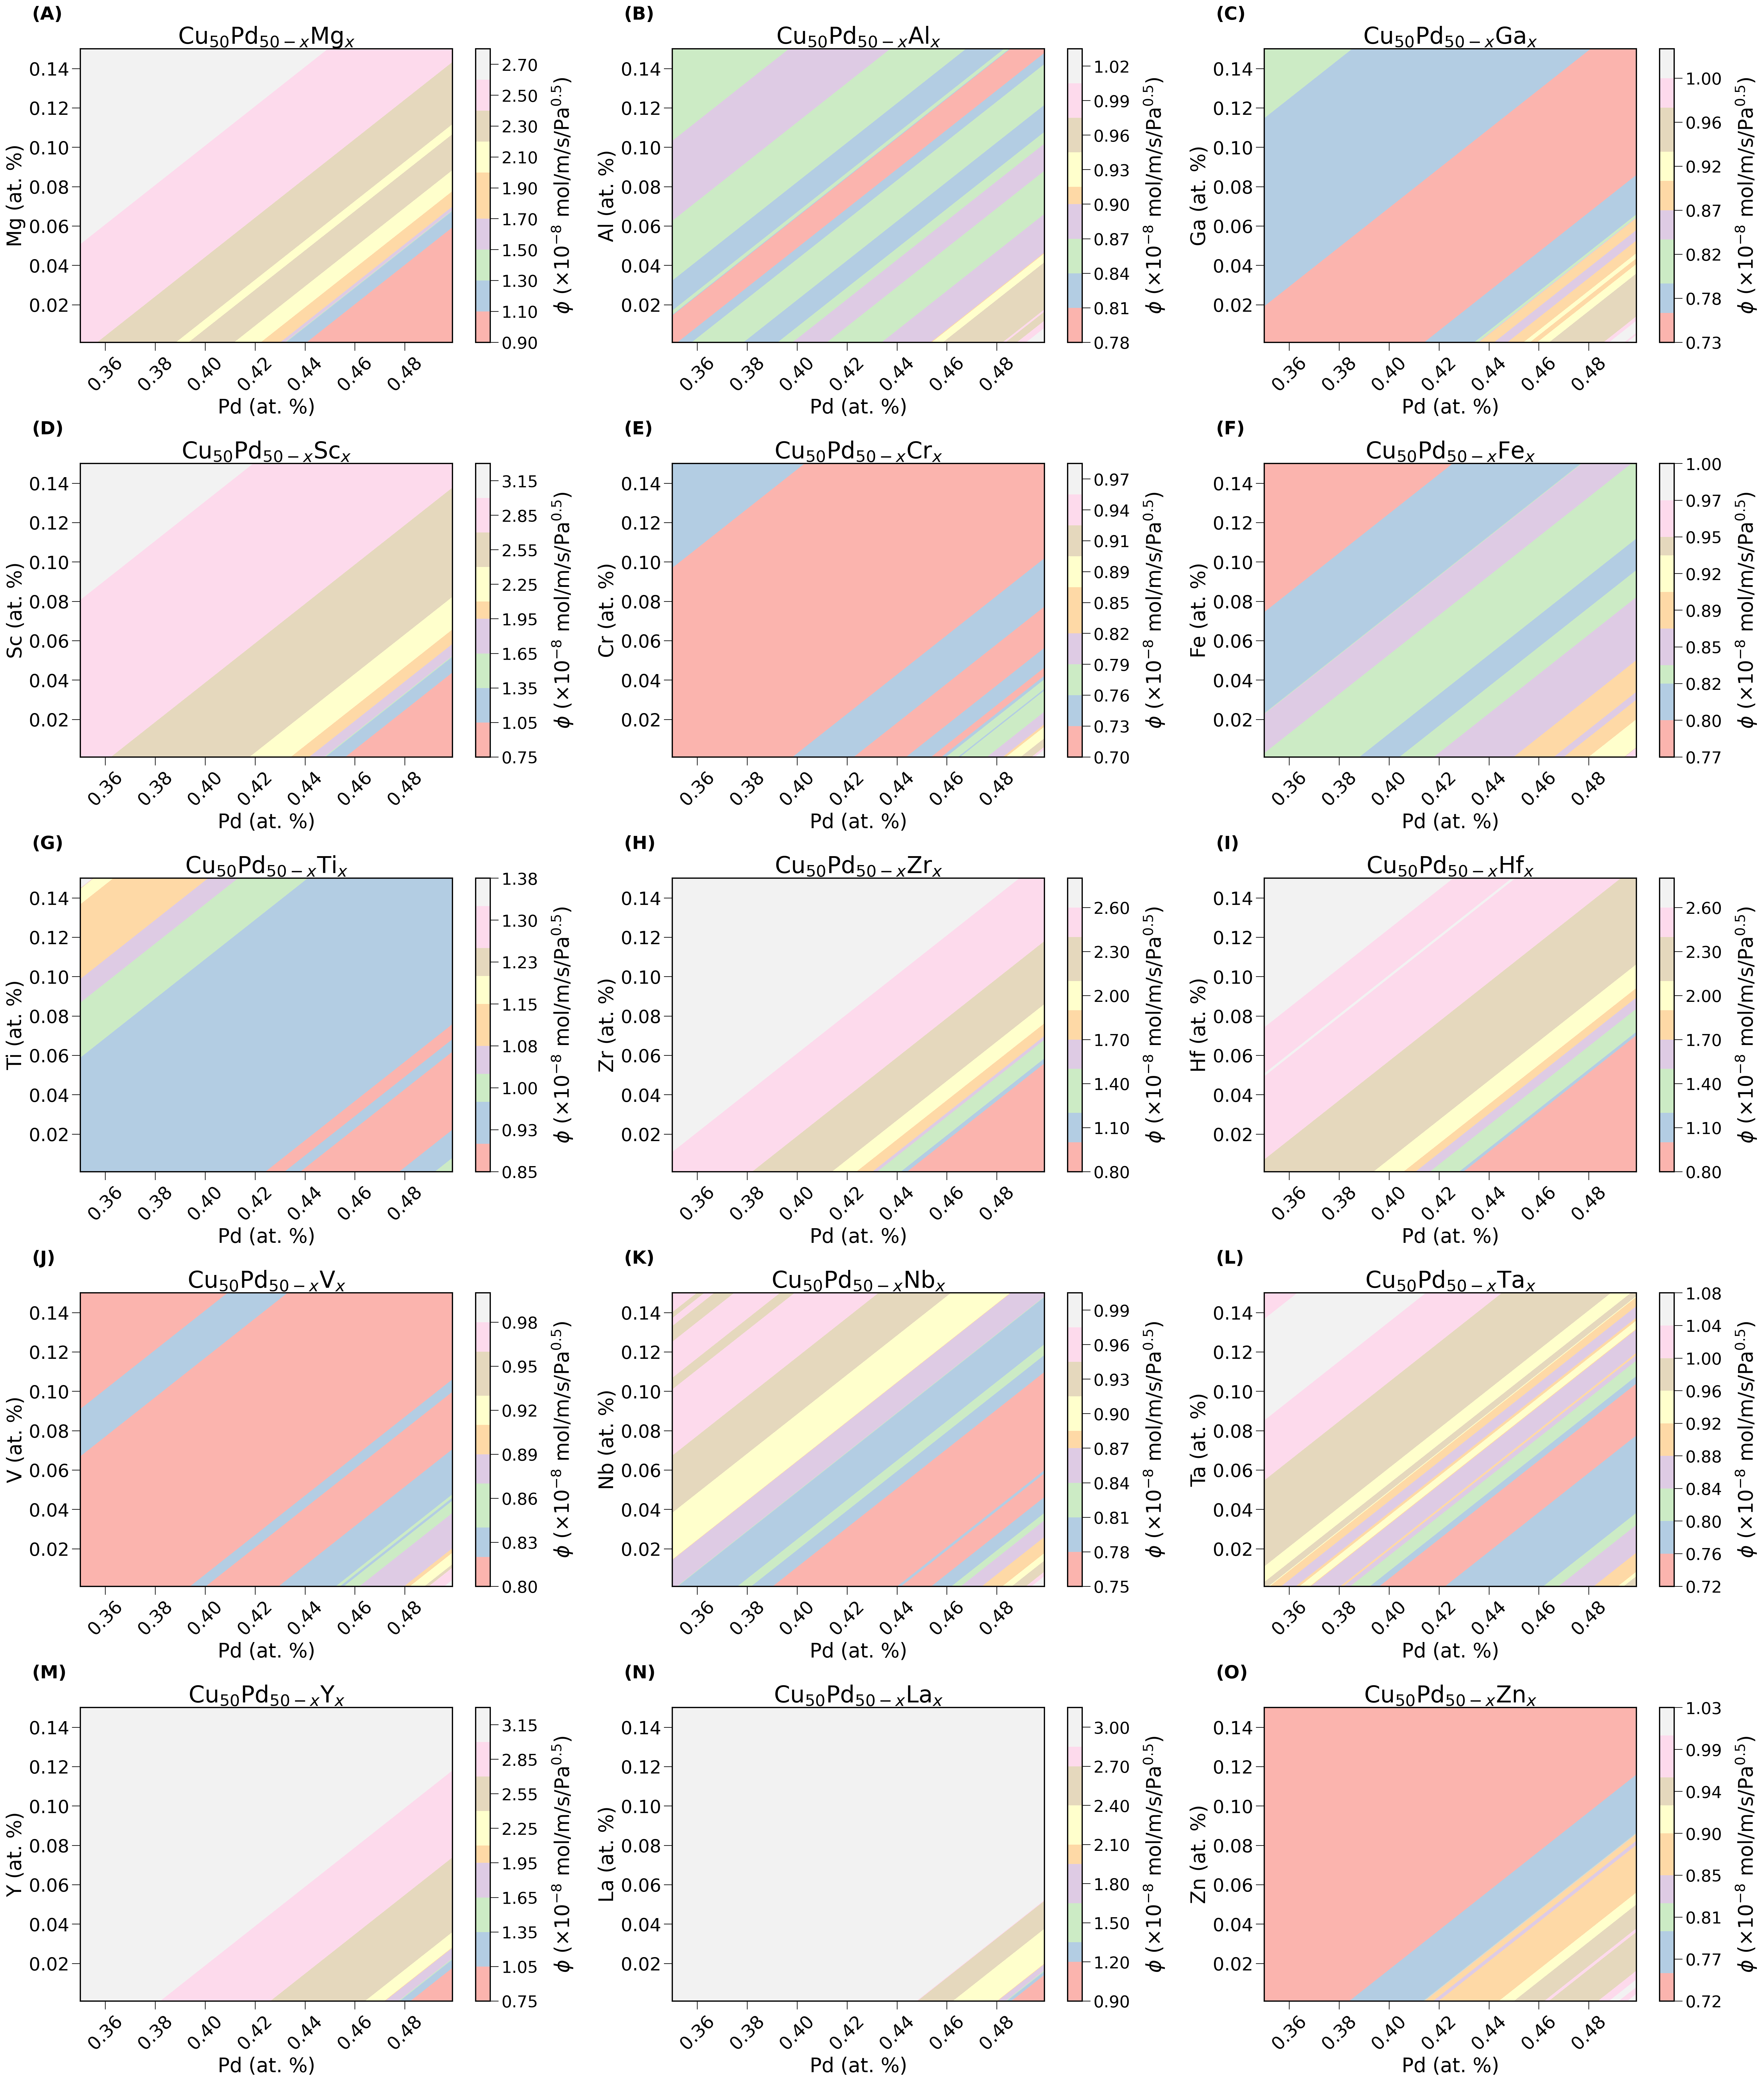

CPU times: user 24.1 s, sys: 430 ms, total: 24.5 s
Wall time: 24.9 s


In [ ]:
%%time
RNG_SEED=42
np.random.seed(RNG_SEED)
# {'Mg','Al','Ga',
#  'Sc','Cr','Fe'
#  'Ti','Zr','Hf',
#  'V', 'Nb','Ta'
#  'La','Y','Zn'}
PdCuAl_alloys_frame_Cu50 = Prediction_virtual_alloys_Cu50_fixed_plotting[Prediction_virtual_alloys_Cu50_fixed_plotting['Component']=='Pd Cu Al']

PdCuCr_alloys_frame_Cu50 = Prediction_virtual_alloys_Cu50_fixed_plotting[Prediction_virtual_alloys_Cu50_fixed_plotting['Component']=='Pd Cu Cr']

PdCuFe_alloys_frame_Cu50 = Prediction_virtual_alloys_Cu50_fixed_plotting[Prediction_virtual_alloys_Cu50_fixed_plotting['Component']=='Pd Cu Fe']

PdCuGa_alloys_frame_Cu50 = Prediction_virtual_alloys_Cu50_fixed_plotting[Prediction_virtual_alloys_Cu50_fixed_plotting['Component']=='Pd Cu Ga']

PdCuHf_alloys_frame_Cu50 = Prediction_virtual_alloys_Cu50_fixed_plotting[Prediction_virtual_alloys_Cu50_fixed_plotting['Component']=='Pd Cu Hf']

PdCuLa_alloys_frame_Cu50 = Prediction_virtual_alloys_Cu50_fixed_plotting[Prediction_virtual_alloys_Cu50_fixed_plotting['Component']=='Pd Cu La']

PdCuMg_alloys_frame_Cu50 = Prediction_virtual_alloys_Cu50_fixed_plotting[Prediction_virtual_alloys_Cu50_fixed_plotting['Component']=='Pd Cu Mg']

PdCuNb_alloys_frame_Cu50 = Prediction_virtual_alloys_Cu50_fixed_plotting[Prediction_virtual_alloys_Cu50_fixed_plotting['Component']=='Pd Cu Nb']

PdCuSc_alloys_frame_Cu50 = Prediction_virtual_alloys_Cu50_fixed_plotting[Prediction_virtual_alloys_Cu50_fixed_plotting['Component']=='Pd Cu Sc']

PdCuTa_alloys_frame_Cu50 = Prediction_virtual_alloys_Cu50_fixed_plotting[Prediction_virtual_alloys_Cu50_fixed_plotting['Component']=='Pd Cu Ta']

PdCuTi_alloys_frame_Cu50 = Prediction_virtual_alloys_Cu50_fixed_plotting[Prediction_virtual_alloys_Cu50_fixed_plotting['Component']=='Pd Cu Ti']

PdCuV_alloys_frame_Cu50 =  Prediction_virtual_alloys_Cu50_fixed_plotting[Prediction_virtual_alloys_Cu50_fixed_plotting['Component']=='Pd Cu V']

PdCuY_alloys_frame_Cu50 =  Prediction_virtual_alloys_Cu50_fixed_plotting[Prediction_virtual_alloys_Cu50_fixed_plotting['Component']=='Pd Cu Y']

PdCuZn_alloys_frame_Cu50 = Prediction_virtual_alloys_Cu50_fixed_plotting[Prediction_virtual_alloys_Cu50_fixed_plotting['Component']=='Pd Cu Zn']

PdCuZr_alloys_frame_Cu50 = Prediction_virtual_alloys_Cu50_fixed_plotting[Prediction_virtual_alloys_Cu50_fixed_plotting['Component']=='Pd Cu Zr']


data_dict= {'PdCuMg': [PdCuMg_alloys_frame_Cu50, 'Mg'],
            'PdCuAl': [PdCuAl_alloys_frame_Cu50, 'Al'],
            'PdCuGa': [PdCuGa_alloys_frame_Cu50, 'Ga'],
            'PdCuSc': [PdCuSc_alloys_frame_Cu50, 'Sc'],
            'PdCuCr': [PdCuCr_alloys_frame_Cu50, 'Cr'],
            'PdCuFe': [PdCuFe_alloys_frame_Cu50, 'Fe'],
            'PdCuTi': [PdCuTi_alloys_frame_Cu50, 'Ti'],
            'PdCuZr': [PdCuZr_alloys_frame_Cu50, 'Zr'],
            'PdCuHf': [PdCuHf_alloys_frame_Cu50, 'Hf'],
            'PdCuV':  [PdCuV_alloys_frame_Cu50,  'V'],
            'PdCuNb': [PdCuNb_alloys_frame_Cu50, 'Nb'],
            'PdCuTa': [PdCuTa_alloys_frame_Cu50, 'Ta'],
            'PdCuY':  [PdCuY_alloys_frame_Cu50,  'Y'],
            'PdCuLa': [PdCuLa_alloys_frame_Cu50, 'La'],
            'PdCuZn': [PdCuZn_alloys_frame_Cu50, 'Zn']
            }

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(30, 35))
for i, ax in enumerate(axes.ravel()):
  key = list(data_dict.keys())[i]
  value = data_dict[key]

  # Step 1: get data values
  x = value[0]['Pd'].values
  y = value[0][value[1]].values
  z = value[0]['Predicted_Permeability'].values*1.0e8

  # Step 2: Create a grid (Pd vs M)
  grid_x, grid_y =  np.meshgrid(np.linspace(x.min(), x.max(), num=200),
                                np.linspace(y.min(), y.max(), num=200))

  # Step 3: Interpolate z values onto grid
  grid_z = griddata(
      points=(x, y),
      values=z,
      xi=(grid_x, grid_y),
      method='nearest' #'linear, 'cubic'
  )

  # Step 4: Mask invalid regions where Pd + M >100 (No needed, I am cautious)
  mask = grid_x + grid_y > 100
  grid_z = np.ma.array(grid_z, mask=mask)

  # Step 5: Plot
  cf = ax.contourf(grid_x, grid_y, grid_z, levels=20, cmap='Pastel1')

  # Step 6: Formatting
  cbar = fig.colorbar(cf, ax=ax)
  # cbar.ax.yaxis.set_major_formatter(FuncFormatter(scientific_formatter))
  cbar.set_label(r'$\phi~\mathrm{(\times10^{-8}~mol/m/s/Pa^{0.5})}$', fontsize=24, labelpad=15)
  ax.set_xlabel('Pd (at. %)', fontsize = 24)
  ax.set_ylabel(f'{value[1]} (at. %)', fontsize = 24)

  # Step 7: Increase major tick length on both x and y axes
  ax.tick_params(axis='both', which='major', length=10) # Adjust 'length' as needed
  ax.set_title(r'$\mathrm{Cu}_{50}\mathrm{Pd}_{50-x}$'+f'{value[1]}'+r'$_{x}$', fontsize = 28)

  # Step 8: Increase the spine linewidth
  for spine in ax.spines.values():
    spine.set_linewidth(1.5)

  for spine in cbar.ax.spines.values():
    spine.set_linewidth(1.5)

  # Step 9: Increase xtick and ytick label sizes
  ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=22, rotation=45)
  ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=22)
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  cbar.ax.tick_params(labelsize=20)
  cbar.ax.tick_params(axis='y', which='major', length=10)
  cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  ax.set_aspect('auto')

  # Step 10: Annotate
  ax.text(-0.13, 1.1, f'({string.ascii_uppercase[i]})', transform=ax.transAxes,
            size=22, weight='bold')

  # Save
  mpl.rcParams['svg.fonttype']='none'
  plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.5, hspace=0.5)
  fig.savefig(fname='/content/drive/MyDrive/PhD_Pd alloy prediction/Figures_Pd_Permeability_Prediction/contour_map_virtual_alloys_Cu50_fixed.svg', bbox_inches='tight', dpi=600, transparent=True)

fig.tight_layout()
plt.show()

In [ ]:
%%time
# Compute Enthalpy of formation using Miedema paradigm
delta_H_mied_Cu50 = Miedema(struct_types='ss', ss_types='min', data_source='Miedema', impute_nan=False)
virtual_alloys_Cu50_fixed_HMiedema = delta_H_mied_Cu50.featurize_dataframe(df=Prediction_virtual_alloys_Cu50_fixed_plotting, col_id='Composition', ignore_errors=True)
virtual_alloys_Cu50_fixed_HMiedema.to_pickle('/content/drive/MyDrive/PhD_Pd alloy prediction/Virtual_alloys_data/virtual_alloys_Cu50_fixed_HMiedema.pkl')

Miedema:   0%|          | 0/2250 [00:00<?, ?it/s]

CPU times: user 404 ms, sys: 6.48 s, total: 6.88 s
Wall time: 6.96 s


In [ ]:
%%time
virtual_alloys_Cu50_fixed_HMiedema=pd.read_pickle('/content/drive/MyDrive/PhD_Pd alloy prediction/Virtual_alloys_data/virtual_alloys_Cu50_fixed_HMiedema.pkl')

CPU times: user 7.11 ms, sys: 1.01 ms, total: 8.13 ms
Wall time: 1.88 s


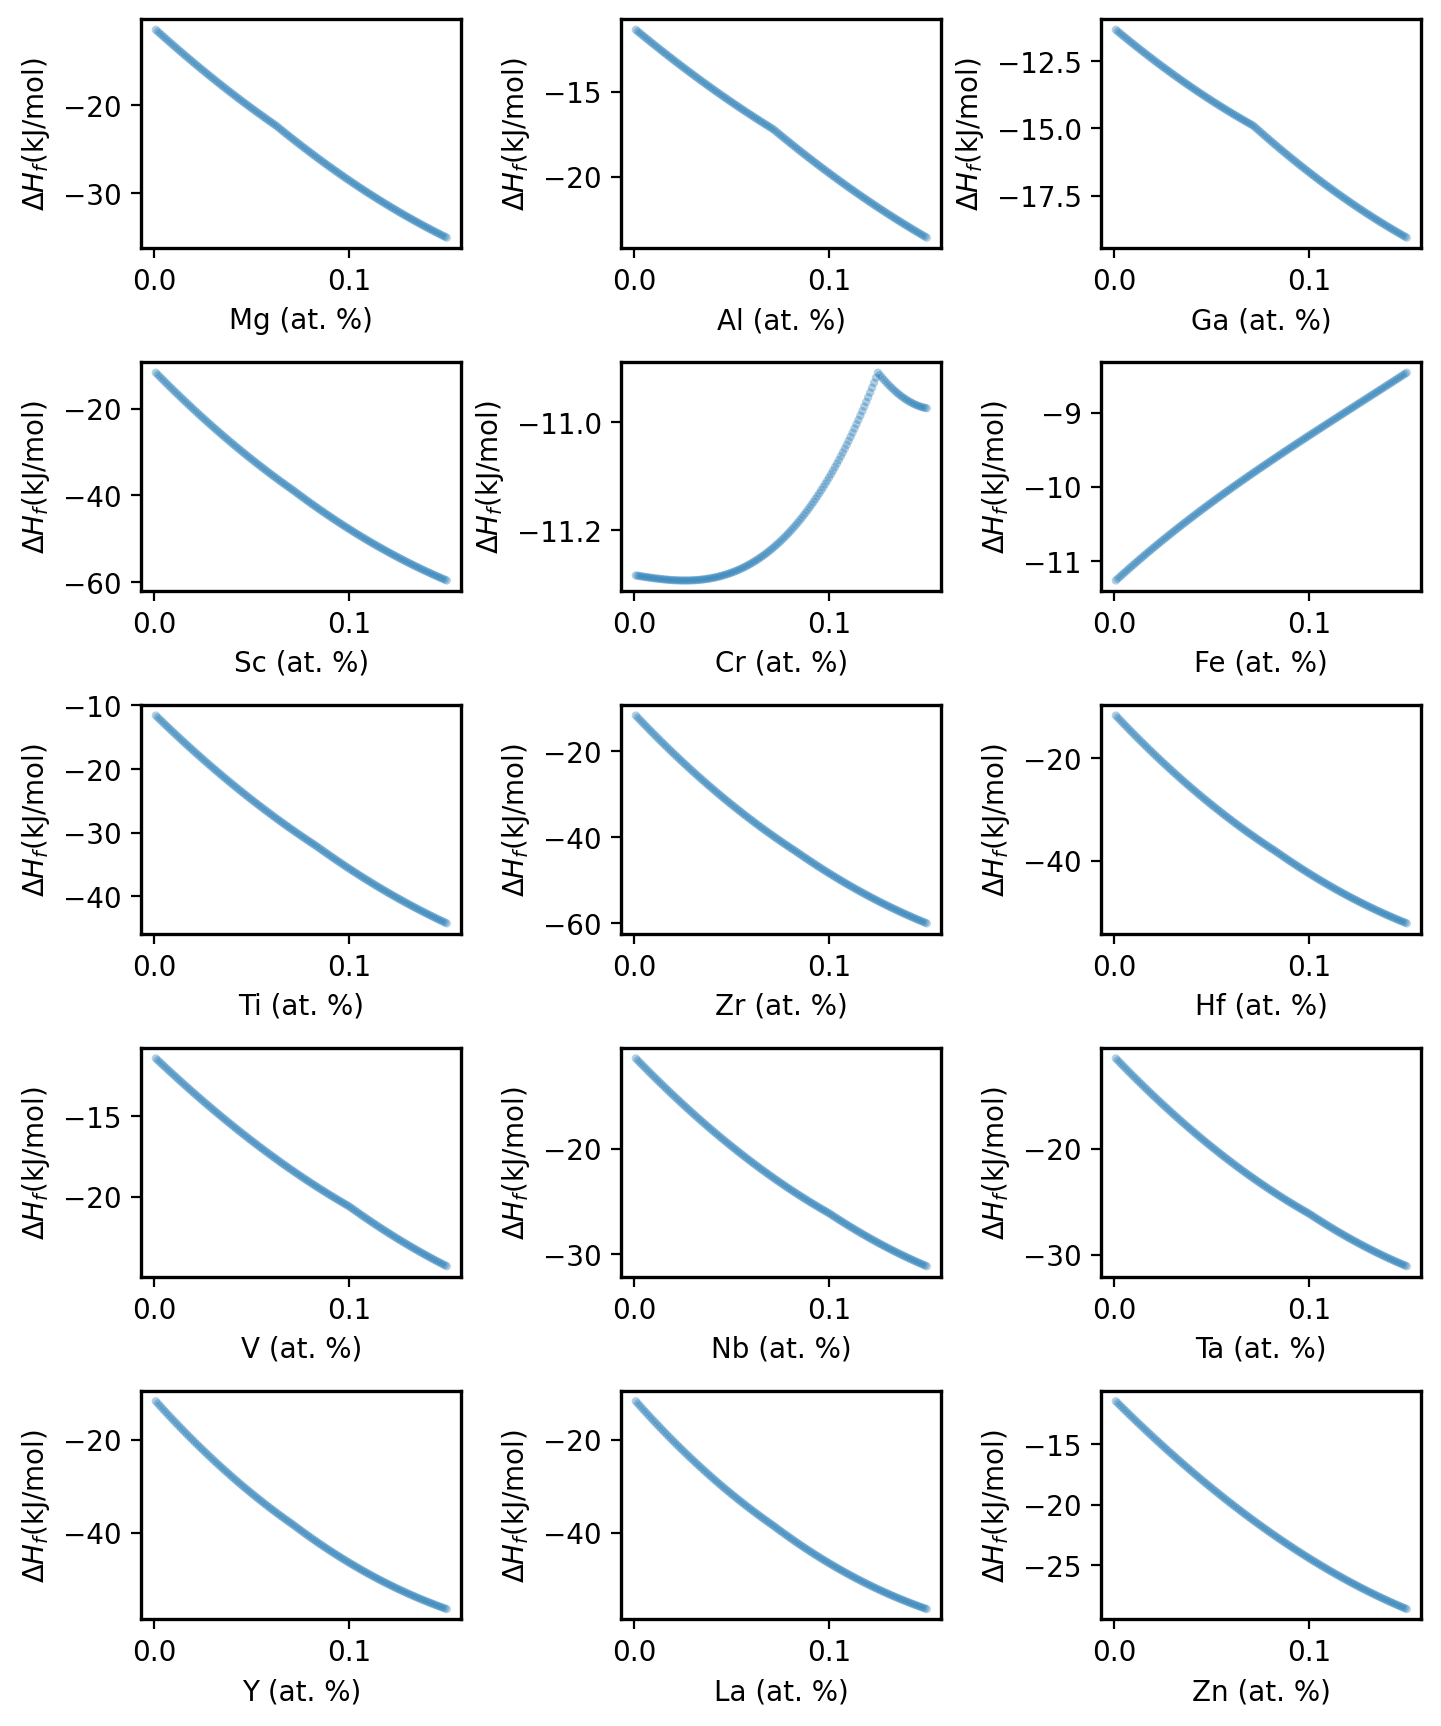

CPU times: user 2.09 s, sys: 29.1 ms, total: 2.12 s
Wall time: 2.65 s


In [ ]:
%%time
# Plotting Miedema enthalpy
PdCuAl_alloys_frame_Mied_Cu50 = virtual_alloys_Cu50_fixed_HMiedema[virtual_alloys_Cu50_fixed_HMiedema['Component']=='Pd Cu Al']

PdCuCr_alloys_frame_Mied_Cu50 = virtual_alloys_Cu50_fixed_HMiedema[virtual_alloys_Cu50_fixed_HMiedema['Component']=='Pd Cu Cr']

PdCuFe_alloys_frame_Mied_Cu50 = virtual_alloys_Cu50_fixed_HMiedema[virtual_alloys_Cu50_fixed_HMiedema['Component']=='Pd Cu Fe']

PdCuGa_alloys_frame_Mied_Cu50 = virtual_alloys_Cu50_fixed_HMiedema[virtual_alloys_Cu50_fixed_HMiedema['Component']=='Pd Cu Ga']

PdCuHf_alloys_frame_Mied_Cu50 = virtual_alloys_Cu50_fixed_HMiedema[virtual_alloys_Cu50_fixed_HMiedema['Component']=='Pd Cu Hf']

PdCuLa_alloys_frame_Mied_Cu50 = virtual_alloys_Cu50_fixed_HMiedema[virtual_alloys_Cu50_fixed_HMiedema['Component']=='Pd Cu La']

PdCuMg_alloys_frame_Mied_Cu50 = virtual_alloys_Cu50_fixed_HMiedema[virtual_alloys_Cu50_fixed_HMiedema['Component']=='Pd Cu Mg']

PdCuNb_alloys_frame_Mied_Cu50 = virtual_alloys_Cu50_fixed_HMiedema[virtual_alloys_Cu50_fixed_HMiedema['Component']=='Pd Cu Nb']

PdCuSc_alloys_frame_Mied_Cu50 = virtual_alloys_Cu50_fixed_HMiedema[virtual_alloys_Cu50_fixed_HMiedema['Component']=='Pd Cu Sc']

PdCuTa_alloys_frame_Mied_Cu50 = virtual_alloys_Cu50_fixed_HMiedema[virtual_alloys_Cu50_fixed_HMiedema['Component']=='Pd Cu Ta']

PdCuTi_alloys_frame_Mied_Cu50 = virtual_alloys_Cu50_fixed_HMiedema[virtual_alloys_Cu50_fixed_HMiedema['Component']=='Pd Cu Ti']

PdCuV_alloys_frame_Mied_Cu50 =  virtual_alloys_Cu50_fixed_HMiedema[virtual_alloys_Cu50_fixed_HMiedema['Component']=='Pd Cu V']

PdCuY_alloys_frame_Mied_Cu50 =  virtual_alloys_Cu50_fixed_HMiedema[virtual_alloys_Cu50_fixed_HMiedema['Component']=='Pd Cu Y']

PdCuZn_alloys_frame_Mied_Cu50 = virtual_alloys_Cu50_fixed_HMiedema[virtual_alloys_Cu50_fixed_HMiedema['Component']=='Pd Cu Zn']

PdCuZr_alloys_frame_Mied_Cu50 = virtual_alloys_Cu50_fixed_HMiedema[virtual_alloys_Cu50_fixed_HMiedema['Component']=='Pd Cu Zr']

data_dict= {'PdCuMg': [PdCuMg_alloys_frame_Mied_Cu50, 'Mg'],
            'PdCuAl': [PdCuAl_alloys_frame_Mied_Cu50, 'Al'],
            'PdCuGa': [PdCuGa_alloys_frame_Mied_Cu50, 'Ga'],
            'PdCuSc': [PdCuSc_alloys_frame_Mied_Cu50, 'Sc'],
            'PdCuCr': [PdCuCr_alloys_frame_Mied_Cu50, 'Cr'],
            'PdCuFe': [PdCuFe_alloys_frame_Mied_Cu50, 'Fe'],
            'PdCuTi': [PdCuTi_alloys_frame_Mied_Cu50, 'Ti'],
            'PdCuZr': [PdCuZr_alloys_frame_Mied_Cu50, 'Zr'],
            'PdCuHf': [PdCuHf_alloys_frame_Mied_Cu50, 'Hf'],
            'PdCuV':  [PdCuV_alloys_frame_Mied_Cu50,  'V'],
            'PdCuNb': [PdCuNb_alloys_frame_Mied_Cu50, 'Nb'],
            'PdCuTa': [PdCuTa_alloys_frame_Mied_Cu50, 'Ta'],
            'PdCuY':  [PdCuY_alloys_frame_Mied_Cu50,  'Y'],
            'PdCuLa': [PdCuLa_alloys_frame_Mied_Cu50, 'La'],
            'PdCuZn': [PdCuZn_alloys_frame_Mied_Cu50, 'Zn']
            }

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(8,10))
for i, ax in enumerate(axes.ravel()):
  key = list(data_dict.keys())[i]
  value = data_dict[key]

  # Step 1: get data values
  x = value[0][value[1]].values
  y = value[0]['Miedema_deltaH_ss_min'].values*96.4853
  pts = ax.scatter(x, y, s=9, edgecolors='none', alpha=0.35)
  pts.set_rasterized(True)
  ax.set_xlabel(f'{value[1]} (at. %)')
  ax.set_ylabel('$\Delta H_{f} \mathrm{(kJ/mol)}$')

  # Step 8: Increase the spine linewidth
  for spine in ax.spines.values():
    spine.set_linewidth(1.2)

# Save
mpl.rcParams['svg.fonttype']='none'
fig.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.5, hspace=0.5)
fig.savefig(fname='/content/drive/MyDrive/PhD_Pd alloy prediction/Figures_Pd_Permeability_Prediction/Delta_H_form_virtual_alloys_Cu50_fixed.svg', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

In [ ]:
%%time
np.random.seed(RNG_SEED)
# PdCuAl_alloys_frame = virtual_alloys_frame_enthalpy_miedema[virtual_alloys_frame_enthalpy_miedema['Component']=='Pd Cu Al']
# Examination_frame = virtual_alloys_frame_enthalpy_miedema[['Virtual_alloys', 'Pd', 'Predicted_Permeability', 'Miedema_deltaH_ss_min']]
# mask = paretoset(Examination_frame, sense=["min", "max", 'min'])
# paretoset_alloys = Examination_frame[mask]

data_dict= {'PdCuMg': PdCuMg_alloys_frame_Mied_Cu50,
            'PdCuAl': PdCuAl_alloys_frame_Mied_Cu50,
            'PdCuGa': PdCuGa_alloys_frame_Mied_Cu50,
            'PdCuSc': PdCuSc_alloys_frame_Mied_Cu50,
            'PdCuCr': PdCuCr_alloys_frame_Mied_Cu50,
            'PdCuFe': PdCuFe_alloys_frame_Mied_Cu50,
            'PdCuTi': PdCuTi_alloys_frame_Mied_Cu50,
            'PdCuZr': PdCuZr_alloys_frame_Mied_Cu50,
            'PdCuHf': PdCuHf_alloys_frame_Mied_Cu50,
            'PdCuV':  PdCuV_alloys_frame_Mied_Cu50,
            'PdCuNb': PdCuNb_alloys_frame_Mied_Cu50,
            'PdCuTa': PdCuTa_alloys_frame_Mied_Cu50,
            'PdCuY':  PdCuY_alloys_frame_Mied_Cu50,
            'PdCuLa': PdCuLa_alloys_frame_Mied_Cu50,
            'PdCuZn': PdCuZn_alloys_frame_Mied_Cu50,
            }

non_dominated_summary = {}
for system, df_sys in data_dict.items():
    mask = paretoset(df_sys[['Pd','Predicted_Permeability','Miedema_deltaH_ss_min']],
                     sense=['min','max','min'])
    efficient = df_sys.loc[mask].copy()
    non_dominated_summary[f'non_dominated_{system}'] = [efficient, efficient.index.tolist()]

all_index = [i for _, (_, idxs) in non_dominated_summary.items() for i in idxs]
Promising_candidate = virtual_alloys_Cu50_fixed_HMiedema.loc[all_index]

CPU times: user 13.4 ms, sys: 2.75 ms, total: 16.2 ms
Wall time: 15.4 ms


In [ ]:
%%time
Promising_candidate

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


Virtual_alloys   Composition  lattice_param  Δa_ss/a_Pd  \
0     Pd35.0Cu50.0Mg15.0  (Pd, Cu, Mg)   3.031349e-10    -0.22075   
7     Pd35.7Cu50.0Mg14.3  (Pd, Cu, Mg)   3.025256e-10    -0.22232   
26    Pd37.6Cu50.0Mg12.4  (Pd, Cu, Mg)   3.008718e-10    -0.22657   
150   Pd35.0Cu50.0Al15.0  (Pd, Cu, Al)   3.072969e-10    -0.21005   
151   Pd35.1Cu50.0Al14.9  (Pd, Cu, Al)   3.071821e-10    -0.21035   
174   Pd37.4Cu50.0Al12.6  (Pd, Cu, Al)   3.045420e-10    -0.21714   
181   Pd38.1Cu50.0Al11.9  (Pd, Cu, Al)   3.037384e-10    -0.21920   
250    Pd45.0Cu50.0Al5.0  (Pd, Cu, Al)   2.958180e-10    -0.23956   
253    Pd45.3Cu50.0Al4.7  (Pd, Cu, Al)   2.954736e-10    -0.24045   
271    Pd47.1Cu50.0Al2.9  (Pd, Cu, Al)   2.934074e-10    -0.24576   
275    Pd47.5Cu50.0Al2.5  (Pd, Cu, Al)   2.929482e-10    -0.24694   
277    Pd47.7Cu50.0Al2.3  (Pd, Cu, Al)   2.927187e-10    -0.24753   
278    Pd47.8Cu50.0Al2.2  (Pd, Cu, Al)   2.926039e-10    -0.24783   
279    Pd47.9Cu50.0Al2.1  (Pd, Cu, Al)   2.924891e-10    -0.24812   
282    Pd48.2Cu50.0Al1.8  (Pd, Cu, Al)   2.921447e-10    -0.24901   
285    Pd48.5Cu50.0Al1.5  (Pd, Cu, Al)   2.918003e-10    -0.24989   
291    Pd49.1Cu50.0Al0.9  (Pd, Cu, Al)   2.911116e-10    -0.25166   
294    Pd49.4Cu50.0Al0.6  (Pd, Cu, Al)   2.907672e-10    -0.25255   
295    Pd49.5Cu50.0Al0.5  (Pd, Cu, Al)   2.906524e-10    -0.25284   
296    Pd49.6Cu50.0Al0.4  (Pd, Cu, Al)   2.905377e-10    -0.25314   
299    Pd49.9Cu50.0Al0.1  (Pd, Cu, Al)   2.901933e-10    -0.25402   
1200  Pd35.0Cu50.0Ga15.0  (Pd, Cu, Ga)   3.274044e-10    -0.15837   
1210  Pd36.0Cu50.0Ga14.0  (Pd, Cu, Ga)   3.249160e-10    -0.16476   
1318   Pd46.8Cu50.0Ga3.2  (Pd, Cu, Ga)   2.980414e-10    -0.23385   
1320   Pd47.0Cu50.0Ga3.0  (Pd, Cu, Ga)   2.975437e-10    -0.23513   
1327   Pd47.7Cu50.0Ga2.3  (Pd, Cu, Ga)   2.958018e-10    -0.23960   
1331   Pd48.1Cu50.0Ga1.9  (Pd, Cu, Ga)   2.948065e-10    -0.24216   
1332   Pd48.2Cu50.0Ga1.8  (Pd, Cu, Ga)   2.945576e-10    -0.24280   
1333   Pd48.3Cu50.0Ga1.7  (Pd, Cu, Ga)   2.943088e-10    -0.24344   
1338   Pd48.8Cu50.0Ga1.2  (Pd, Cu, Ga)   2.930646e-10    -0.24664   
1343   Pd49.3Cu50.0Ga0.7  (Pd, Cu, Ga)   2.918204e-10    -0.24984   
1344   Pd49.4Cu50.0Ga0.6  (Pd, Cu, Ga)   2.915715e-10    -0.25048   
1348   Pd49.8Cu50.0Ga0.2  (Pd, Cu, Ga)   2.905762e-10    -0.25304   
300   Pd35.0Cu50.0Sc15.0  (Pd, Cu, Sc)   3.046482e-10    -0.21686   
303   Pd35.3Cu50.0Sc14.7  (Pd, Cu, Sc)   3.043568e-10    -0.21761   
750   Pd35.0Cu50.0Cr15.0  (Pd, Cu, Cr)   2.898269e-10    -0.25496   
765   Pd36.5Cu50.0Cr13.5  (Pd, Cu, Cr)   2.898521e-10    -0.25490   
783   Pd38.3Cu50.0Cr11.7  (Pd, Cu, Cr)   2.898823e-10    -0.25482   
784   Pd38.4Cu50.0Cr11.6  (Pd, Cu, Cr)   2.898840e-10    -0.25482   
785   Pd38.5Cu50.0Cr11.5  (Pd, Cu, Cr)   2.898856e-10    -0.25481   
786   Pd38.6Cu50.0Cr11.4  (Pd, Cu, Cr)   2.898873e-10    -0.25481   
787   Pd38.7Cu50.0Cr11.3  (Pd, Cu, Cr)   2.898890e-10    -0.25480   
788   Pd38.8Cu50.0Cr11.2  (Pd, Cu, Cr)   2.898907e-10    -0.25480   
789   Pd38.9Cu50.0Cr11.1  (Pd, Cu, Cr)   2.898924e-10    -0.25480   
790   Pd39.0Cu50.0Cr11.0  (Pd, Cu, Cr)   2.898940e-10    -0.25479   
791   Pd39.1Cu50.0Cr10.9  (Pd, Cu, Cr)   2.898957e-10    -0.25479   
792   Pd39.2Cu50.0Cr10.8  (Pd, Cu, Cr)   2.898974e-10    -0.25478   
793   Pd39.3Cu50.0Cr10.7  (Pd, Cu, Cr)   2.898991e-10    -0.25478   
794   Pd39.4Cu50.0Cr10.6  (Pd, Cu, Cr)   2.899007e-10    -0.25477   
795   Pd39.5Cu50.0Cr10.5  (Pd, Cu, Cr)   2.899024e-10    -0.25477   
796   Pd39.6Cu50.0Cr10.4  (Pd, Cu, Cr)   2.899041e-10    -0.25477   
797   Pd39.7Cu50.0Cr10.3  (Pd, Cu, Cr)   2.899058e-10    -0.25476   
798   Pd39.8Cu50.0Cr10.2  (Pd, Cu, Cr)   2.899074e-10    -0.25476   
799   Pd39.9Cu50.0Cr10.1  (Pd, Cu, Cr)   2.899091e-10    -0.25475   
800   Pd40.0Cu50.0Cr10.0  (Pd, Cu, Cr)   2.899108e-10    -0.25475   
801    Pd40.1Cu50.0Cr9.9  (Pd, Cu, Cr)   2.899125e-10    -0.25474   
802    Pd40.2Cu50.0Cr9.8  (Pd, Cu, Cr)   2.899142e-10    -0.25474   
803    P

In [ ]:
%%time
# For every system I will chose:
# The alloy with highest permeability,
# The alloy with smallest enthalpy of formation
# The alloy with smallest Pd content

# columns needed: Component, Predicted_Permeability, Pd, Miedema_deltaH_ss_min
final_rows = []

for system in Promising_candidate['Component'].unique():
    current = Promising_candidate.loc[Promising_candidate['Component'] == system]\
                                 .dropna(subset=['Predicted_Permeability','Pd','Miedema_deltaH_ss_min'])

    best_perm   = current.loc[[current['Predicted_Permeability'].idxmax()]].assign(selection='max_perm')
    smallest_Pd = current.loc[[current['Pd'].idxmin()]].assign(selection='min_Pd')
    smallest_H  = current.loc[[current['Miedema_deltaH_ss_min'].idxmin()]].assign(selection='min_dH')

    final_rows += [best_perm, smallest_Pd, smallest_H]

final_result_frame = pd.concat(final_rows, ignore_index=True)

# Optional: if the same alloy wins multiple criteria, keep one row per alloy/system
if 'virtual alloys' in final_result_frame.columns:
    final_result_frame = final_result_frame.drop_duplicates(subset=['Component','virtual alloys'])

CPU times: user 46.6 ms, sys: 1.02 ms, total: 47.6 ms
Wall time: 46.5 ms


In [ ]:
final_result_frame

Virtual_alloys   Composition  lattice_param  Δa_ss/a_Pd  \
0   Pd37.6Cu50.0Mg12.4  (Pd, Cu, Mg)   3.008718e-10    -0.22657   
1   Pd35.0Cu50.0Mg15.0  (Pd, Cu, Mg)   3.031349e-10    -0.22075   
2   Pd35.0Cu50.0Mg15.0  (Pd, Cu, Mg)   3.031349e-10    -0.22075   
3    Pd49.9Cu50.0Al0.1  (Pd, Cu, Al)   2.901933e-10    -0.25402   
4   Pd35.0Cu50.0Al15.0  (Pd, Cu, Al)   3.072969e-10    -0.21005   
5   Pd35.0Cu50.0Al15.0  (Pd, Cu, Al)   3.072969e-10    -0.21005   
6    Pd49.8Cu50.0Ga0.2  (Pd, Cu, Ga)   2.905762e-10    -0.25304   
7   Pd35.0Cu50.0Ga15.0  (Pd, Cu, Ga)   3.274044e-10    -0.15837   
8   Pd35.0Cu50.0Ga15.0  (Pd, Cu, Ga)   3.274044e-10    -0.15837   
9   Pd35.3Cu50.0Sc14.7  (Pd, Cu, Sc)   3.043568e-10    -0.21761   
10  Pd35.0Cu50.0Sc15.0  (Pd, Cu, Sc)   3.046482e-10    -0.21686   
11  Pd35.0Cu50.0Sc15.0  (Pd, Cu, Sc)   3.046482e-10    -0.21686   
12   Pd49.9Cu50.0Cr0.1  (Pd, Cu, Cr)   2.900768e-10    -0.25432   
13  Pd35.0Cu50.0Cr15.0  (Pd, Cu, Cr)   2.898269e-10    -0.25496   
14   Pd47.4Cu50.0Cr2.6  (Pd, Cu, Cr)   2.900349e-10    -0.25443   
15   Pd49.9Cu50.0Fe0.1  (Pd, Cu, Fe)   2.900750e-10    -0.25433   
16  Pd35.0Cu50.0Fe15.0  (Pd, Cu, Fe)   2.895524e-10    -0.25567   
17   Pd49.9Cu50.0Fe0.1  (Pd, Cu, Fe)   2.900750e-10    -0.25433   
18  Pd35.0Cu50.0Ti15.0  (Pd, Cu, Ti)   2.981802e-10    -0.23349   
19  Pd35.0Cu50.0Ti15.0  (Pd, Cu, Ti)   2.981802e-10    -0.23349   
20  Pd35.0Cu50.0Ti15.0  (Pd, Cu, Ti)   2.981802e-10    -0.23349   
21  Pd35.0Cu50.0Zr15.0  (Pd, Cu, Zr)   3.031619e-10    -0.22068   
22  Pd35.0Cu50.0Zr15.0  (Pd, Cu, Zr)   3.031619e-10    -0.22068   
23  Pd35.0Cu50.0Zr15.0  (Pd, Cu, Zr)   3.031619e-10    -0.22068   
24  Pd35.1Cu50.0Hf14.9  (Pd, Cu, Hf)   3.022978e-10    -0.22291   
25  Pd35.0Cu50.0Hf15.0  (Pd, Cu, Hf)   3.023798e-10    -0.22269   
26  Pd35.0Cu50.0Hf15.0  (Pd, Cu, Hf)   3.023798e-10    -0.22269   
27    Pd49.9Cu50.0V0.1   (Pd, Cu, V)   2.900907e-10    -0.25429   
28   Pd35.0Cu50.0V15.0   (Pd, Cu, V)   2.919149e-10    -0.24960   
29   Pd35.0Cu50.0V15.0   (Pd, Cu, V)   2.919149e-10    -0.24960   
30   Pd49.9Cu50.0Nb0.1  (Pd, Cu, Nb)   2.901184e-10    -0.25421   
31  Pd35.0Cu50.0Nb15.0  (Pd, Cu, Nb)   2.960610e-10    -0.23894   
32  Pd35.0Cu50.0Nb15.0  (Pd, Cu, Nb)   2.960610e-10    -0.23894   
33  Pd36.4Cu50.0Ta13.6  (Pd, Cu, Ta)   2.955379e-10    -0.24028   
34  Pd35.0Cu50.0Ta15.0  (Pd, Cu, Ta)   2.960999e-10    -0.23884   
35  Pd35.0Cu50.0Ta15.0  (Pd, Cu, Ta)   2.960999e-10    -0.23884   
36    Pd40.9Cu50.0Y9.1   (Pd, Cu, Y)   3.107087e-10    -0.20128   
37   Pd35.0Cu50.0Y15.0   (Pd, Cu, Y)   3.240843e-10    -0.16690   
38   Pd35.0Cu50.0Y15.0   (Pd, Cu, Y)   3.240843e-10    -0.16690   
39   Pd46.6Cu50.0La3.4  (Pd, Cu, La)   2.982185e-10    -0.23339   
40  Pd35.0Cu50.0La15.0  (Pd, Cu, La)   3.259901e-10    -0.16200   
41  Pd35.0Cu50.0La15.0  (Pd, Cu, La)   3.259901e-10    -0.16200   
42   Pd49.9Cu50.0Zn0.1  (Pd, Cu, Zn)   2.901159e-10    -0.25422   
43  Pd35.0Cu50.0Zn15.0  (Pd, Cu, Zn)   2.956815e-10    -0.23991   
44  Pd35.0Cu50.0Zn15.0  (Pd, Cu, Zn)   2.956815e-10    -0.23991   

    No of Components Component Moles of individual Components  Total Moles  \
0                  3  Pd Cu Mg                 37.6 50.0 12.4        100.0   
1                  3  Pd Cu Mg                 35.0 50.0 15.0        100.0   
2                  3  Pd Cu Mg                 35.0 50.0 15.0        100.0   
3                  3  Pd Cu Al                  49.9 50.0 0.1        100.0   
4                  3  Pd Cu Al                 35.0 50.0 15.0        100.0   
5                  3  Pd Cu Al                 35.0 50.0 15.0        100.0   
6                  3  Pd Cu Ga                  49.8 50.0 0.2        100.0   
7                  3  Pd Cu Ga                 35.0 50.0 15.0        100.0   
8                  3  Pd Cu Ga                 35.0 50.0 15.0        100.0   
9                  3  Pd Cu Sc                 35.3 50.0 14.7        100.0   
10                 3  Pd Cu Sc                 35.0 50.0 15.0      

In [ ]:
!pip install CBFV

In [ ]:
import CBFV
from CBFV.composition import _fractional_composition


In [ ]:
####### saving the element and their corresponding atomic weight in a dictionary ############
ele_weight = pd.read_csv('/usr/local/lib/python3.12/dist-packages/CBFV/element_properties/magpie.csv')
ele_prop_frame = ele_weight.set_index('element').reset_index(drop=False)

In [ ]:
ele_wt_dict = {k:v for k, v in zip(ele_prop_frame.element, ele_prop_frame.AtomicWeight)}

In [ ]:
ele_wt_dict

{'H': 1.00794,
 'He': 4.002602,
 'Li': 6.941,
 'Be': 9.012182,
 'B': 10.811,
 'C': 12.0107,
 'N': 14.0067,
 'O': 15.9994,
 'F': 18.9984032,
 'Ne': 20.1791,
 'Na': 22.98976928,
 'Mg': 24.305,
 'Al': 26.9815386,
 'Si': 28.0855,
 'P': 30.973762,
 'S': 32.065,
 'Cl': 35.453,
 'Ar': 39.948,
 'K': 39.0983,
 'Ca': 40.078,
 'Sc': 44.955912,
 'Ti': 47.867,
 'V': 50.9415,
 'Cr': 51.9961,
 'Mn': 54.938045,
 'Fe': 55.845,
 'Co': 58.933195,
 'Ni': 58.6934,
 'Cu': 63.546,
 'Zn': 65.38,
 'Ga': 69.723,
 'Ge': 72.64,
 'As': 74.9216,
 'Se': 78.96,
 'Br': 79.904,
 'Kr': 83.798,
 'Rb': 85.4678,
 'Sr': 87.62,
 'Y': 88.90585,
 'Zr': 91.224,
 'Nb': 92.90638,
 'Mo': 95.96,
 'Tc': 98.0,
 'Ru': 101.07,
 'Rh': 102.9055,
 'Pd': 106.42,
 'Ag': 107.8682,
 'Cd': 112.411,
 'In': 114.818,
 'Sn': 118.71,
 'Sb': 121.76,
 'Te': 127.6,
 'I': 126.90447,
 'Xe': 131.293,
 'Cs': 132.9054519,
 'Ba': 137.327,
 'La': 138.90547,
 'Ce': 140.116,
 'Pr': 140.90765,
 'Nd': 144.242,
 'Pm': 145.0,
 'Sm': 150.36,
 'Eu': 151.964,
 'Gd': 

In [ ]:
from decimal import Decimal, ROUND_HALF_UP

def atpct_to_wtpct(formula: str, ele_wt_dict: dict, decimals: int = 1, return_dict: bool = False):
    """
    Convert an alloy composition in atomic % (e.g. 'Pd46.6Cu46.9La6.5')
    to weight %, with the rounded parts summing EXACTLY to 100.0 at `decimals`.

    Parameters
    ----------
    formula : str
        e.g. 'Pd46.6Cu46.9La6.5' (order preserved in output if your parser preserves it)
    ele_wt_dict : dict
        Atomic weights, e.g. {'Pd': 106.42, 'Cu': 63.546, 'La': 138.905}
    decimals : int
        Number of decimals in the output (default 1)
    return_dict : bool
        If True, return an OrderedDict-like dict {elem: wt%}; else return a compact string.
    """
    # 1) Parse to fractional atomic composition (must sum to 100 or to 1; normalize if needed)
    frac_dict = _fractional_composition(formula)  # your existing parser; values are atomic fractions (0..1) or at%

    # Normalize if user passed atomic percent (sum~100). Accept both.
    total_frac = sum(frac_dict.values())
    if total_frac == 0:
        raise ValueError("Parsed composition is empty.")
    if total_frac > 1.5:  # assume it's atomic percent; convert to fraction
        frac_dict = {k: v / total_frac for k, v in frac_dict.items()}
    else:
        # already fractional; ensure exact normalization
        frac_dict = {k: v / total_frac for k, v in frac_dict.items()}

    # 2) Compute unrounded weight percentages (as Decimals for stable rounding)
    masses = {el: Decimal(str(ele_wt_dict[el])) * Decimal(str(frac))
              for el, frac in frac_dict.items()}
    total_mass = sum(masses.values())
    if total_mass == 0:
        raise ValueError("Total mass computed as zero; check atomic weights.")

    raw_pct = {el: (m / total_mass) * Decimal('100') for el, m in masses.items()}

    # 3) Round with HALF_UP and then force-balance so the sum equals exactly 100.0
    q = Decimal('1.' + '0' * decimals) if decimals > 0 else Decimal('1')
    rounded = {el: raw.quantize(q, rounding=ROUND_HALF_UP) for el, raw in raw_pct.items()}
    sum_rounded = sum(rounded.values())
    target = Decimal('100').quantize(q)  # e.g., 100.0 with the right number of decimals
    diff = target - sum_rounded

    if diff != 0:
        # Adjust the element with the largest raw percentage (stable choice)
        # Alternatively, adjust by largest remainder: raw - rounded
        adjust_el = max(raw_pct.keys(), key=lambda e: raw_pct[e])
        rounded[adjust_el] = (rounded[adjust_el] + diff).quantize(q, rounding=ROUND_HALF_UP)

    # 4) Clamp any tiny negatives to zero and re-balance (extremely rare, but safe)
    # If clamped, push the removed amount into the largest component again.
    neg_total = sum(v for v in rounded.values() if v < 0)
    if neg_total < 0:
        # zero out negatives
        for el, v in list(rounded.items()):
            if v < 0:
                rounded[el] = Decimal('0').quantize(q)
        # add back the removed magnitude to the largest component
        adjust_el = max(rounded.keys(), key=lambda e: rounded[e])
        rounded[adjust_el] = (rounded[adjust_el] - neg_total).quantize(q, rounding=ROUND_HALF_UP)

    # 5) Return in chosen format
    if return_dict:
        # Convert Decimals to floats for convenience
        return {el: float(v) for el, v in rounded.items()}
    else:
        # Compact string like 'Pd56.1Cu33.7La10.2' with fixed decimals
        fmt = f"{{:.{decimals}f}}"
        parts = [f"{el}{fmt.format(float(rounded[el]))}" for el in rounded]
        return "".join(parts)


In [ ]:
atpct_to_wtpct(formula='Pd44.4Cu35.6Zn20.0', ele_wt_dict=ele_wt_dict, decimals=2, return_dict=False)

'Pd56.97Cu27.27Zn15.76'

In [ ]:
53.8+39.4+6.8

99.99999999999999